In [60]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [61]:
# Install necessary packages if not already installed
!pip install pandas numpy matplotlib seaborn nltk scikit-learn tensorflow --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings
warnings.filterwarnings('ignore')

# Sentiment Analysis of Movie Reviews using RNNs

This notebook presents a comprehensive workflow for building and evaluating Recurrent Neural Network (RNN) models (SimpleRNN, LSTM, GRU) for sentiment analysis of movie reviews. The dataset contains reviews in multiple languages, including Malay. We will cover data exploration, preprocessing, feature engineering, model building, evaluation, and improvement.

In [62]:
# Load the dataset
df = pd.read_csv('Movie reviews.csv')
print("Shape of dataset:", df.shape)
df.head()

Shape of dataset: (527, 4)


,Review,Score,"Are there ways for you to generate more data? Spliting up sentences, would that help?",Language
0,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.1,NaN,Malay
1,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.9,NaN,Malay
2,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.5,NaN,Malay
3,"Sayang sekali, pelakon tidak memberikan persem...",0.8,NaN,Malay
4,Jalan cerita yang kompleks dan penuh emosi. Su...,0.2,NaN,Malay


## Dropping unwanted Columns

In [63]:
df = df.drop(columns=['Are there ways for you to generate more data? Spliting up sentences, would that help?'])


In [64]:
df

,Review,Score,Language
0,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.1,Malay
1,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.9,Malay
2,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.5,Malay
3,"Sayang sekali, pelakon tidak memberikan persem...",0.8,Malay
4,Jalan cerita yang kompleks dan penuh emosi. Su...,0.2,Malay
...,...,...,...
522,Pening,0.7,Malay
523,Berkesan,0.2,Malay
524,Mengujakan,0.1,Malay
525,Sederhana and teruk,0.6,Malay



- **Count**: 525 non-null entries, indicating 2 missing values.
- **Mean**: The average score across all entries is 0.2826.
- **Standard Deviation (std)**: 0.263, showing variability in the scores.
- **Min/Max**: The lowest score is 0.0010, and the highest score is 0.9974, reflecting a wide range of values.
- **Quartiles**:
  - 25%: 0.1000 (lower quartile)
  - 50% (Median): 0.1200
  - 75%: 0.5000 (upper quartile)

This summary suggests that the majority of the scores are on the lower end of the scale, with a few higher values pushing the maximum score close to 1.


In [65]:
# Show basic info
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 527 entries, 0 to 526
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Review    527 non-null    object 
 1   Score     525 non-null    float64
 2   Language  527 non-null    object 
dtypes: float64(1), object(2)
memory usage: 12.5+ KB


,Score
count,525.000000
mean,0.282626
std,0.263022
min,0.001000
25%,0.100000
50%,0.120000
75%,0.500000
max,0.997413


## Two Missing values Found

In [66]:
# Check for missing values
df.isnull().sum()

Review      0
Score       2
Language    0
dtype: int64

## Dropped it

In [67]:
df = df.dropna(subset=['Score'])
df.isnull().sum()

Review      0
Score       0
Language    0
dtype: int64

## Check the diff Languages

In [68]:
unique_languages = df['Language'].unique()

print(unique_languages)

['Malay' 'English' 'Chinese' 'Nippon']



## This code will produce a visual display of word clouds, one for each language in the dataset, showing the most frequent words in the reviews for each language.


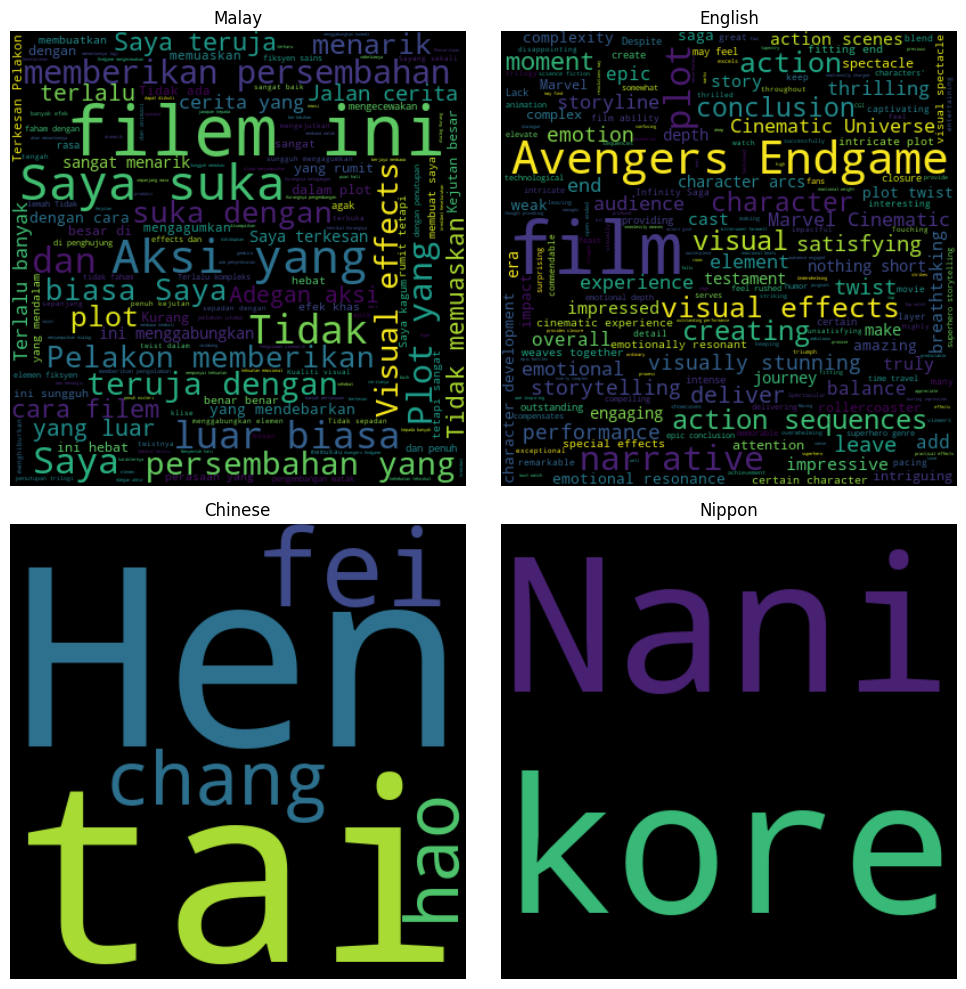

In [69]:
#pip install wordcloud matplotlib

import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Group the data by 'Language' and concatenate all reviews for each language
languages = df['Language'].unique()

# Set up the figure for plotting
plt.figure(figsize=(10, 10))

for i, language in enumerate(languages):
    # Filter the data for the current language
    text = ' '.join(df[df['Language'] == language]['Review'])
    
    # Create the word cloud
    wordcloud = WordCloud(width=400, height=400, background_color='black').generate(text)
    
    # Plot the word cloud
    plt.subplot(2, 2, i+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(language)
    plt.axis('off')

# Show the plot
plt.tight_layout()
plt.show()


### Evaluation of the Histogram:

3. **Result**:
   - The histogram indicates the distribution of sentiment scores across the reviews, with certain score ranges having significantly higher frequencies. This suggests that the dataset is not evenly distributed in terms of sentiment but has specific score ranges with more reviews.
   - The code is useful for visualizing the overall sentiment distribution of the reviews based on their scores.


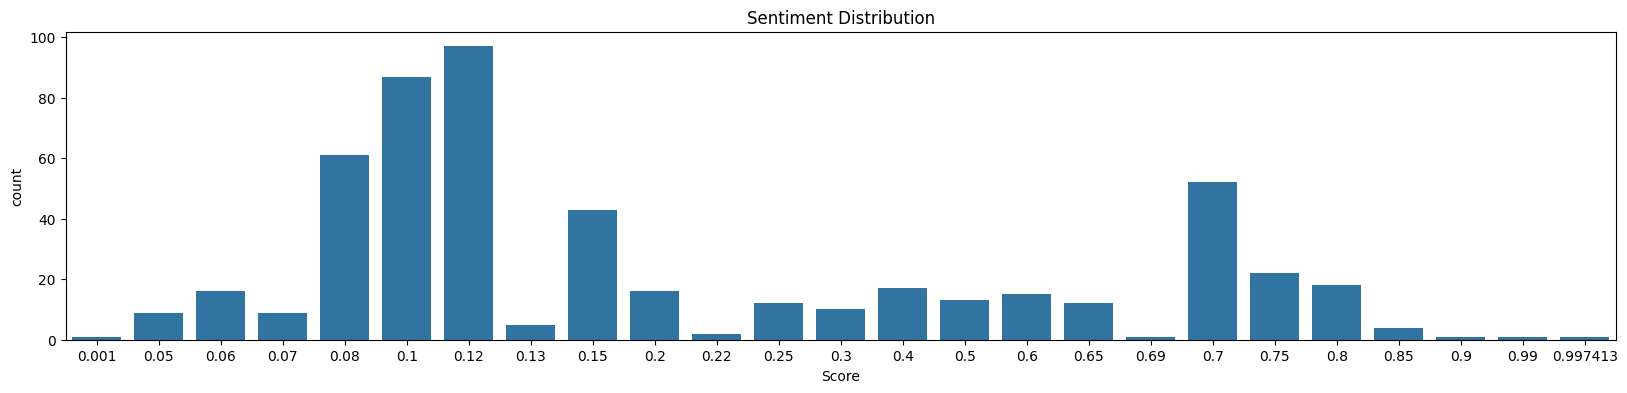

In [70]:
# Show sentiment distribution
plt.figure(figsize=(20,4))
sns.countplot(x='Score', data=df)
plt.title('Sentiment Distribution')
plt.show()

In [71]:
# df['word_count'] = df['Review'].apply(lambda x: len(str(x).split()))

# # Create a histogram with a KDE plot for the word count per review
# plt.figure(figsize=(10, 6))
# sns.histplot(df['word_count'], kde=True, color='red', bins=30)

# # Set labels and title
# plt.title('Count Words Per Review')
# plt.xlabel('Length of Review')
# plt.ylabel('Count')

# # Show the plot
# plt.show()

### Dataset Overview

- **Rows:** Number of reviews.
- **Columns:** Typically includes 'review' (text) and 'sentiment' (label or score).
- **Missing Values:** Check and handle accordingly.
- **Sentiment Distribution:** Ensure balanced classes for classification tasks.

In [72]:
df

,Review,Score,Language
0,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.1,Malay
1,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.9,Malay
2,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.5,Malay
3,"Sayang sekali, pelakon tidak memberikan persem...",0.8,Malay
4,Jalan cerita yang kompleks dan penuh emosi. Su...,0.2,Malay
...,...,...,...
522,Pening,0.7,Malay
523,Berkesan,0.2,Malay
524,Mengujakan,0.1,Malay
525,Sederhana and teruk,0.6,Malay


## We Converted the non-english-languages using Google translate to English, this lets us see the data and understand what each review is about

In [73]:
import pandas as pd
from googletrans import Translator
import time
import numpy as np

def translate_reviews_to_english(df):
    """
    Translate all non-English reviews to English using Google Translate
    
    Parameters:
    df: DataFrame with columns ['Review', 'Score', 'Language']
    
    Returns:
    DataFrame with additional 'Review_English' column
    """
    
    # Initialize translator
    translator = Translator()
    
    # Create a copy of the dataframe
    df_translated = df.copy()
    
    # Add new column for English translations
    df_translated['Review_English'] = df_translated['Review'].copy()
    
    # Language mapping for googletrans
    lang_map = {
        'Malay': 'ms',
        'Chinese': 'zh',
        'Nippon': 'ja',  # Japanese
        'English': 'en'
    }
    
    # Track progress
    total_to_translate = len(df_translated[df_translated['Language'] != 'English'])
    translated_count = 0
    
    print(f"Starting translation of {total_to_translate} non-English reviews...")
    
    # Translate non-English reviews
    for idx, row in df_translated.iterrows():
        if row['Language'] != 'English':
            try:
                # Get source language code
                src_lang = lang_map.get(row['Language'], 'auto')
                
                # Translate to English
                translation = translator.translate(
                    row['Review'], 
                    src=src_lang, 
                    dest='en'
                )
                
                # Update the English review column
                df_translated.at[idx, 'Review_English'] = translation.text
                
                translated_count += 1
                
                # Progress update
                if translated_count % 10 == 0:
                    print(f"Translated {translated_count}/{total_to_translate} reviews...")
                
                # Small delay to avoid rate limiting
                time.sleep(0.1)
                
            except Exception as e:
                print(f"Error translating row {idx}: {e}")
                # Keep original text if translation fails
                df_translated.at[idx, 'Review_English'] = row['Review']
    
    print(f"Translation complete! Translated {translated_count} reviews.")
    
    return df_translated

# Usage example:
# df_with_translations = translate_reviews_to_english(df)

# Optional: Save the results
def save_translated_reviews(df_translated, filename='translated_reviews.csv'):
    """Save the translated dataframe to CSV"""
    df_translated.to_csv(filename, index=False, encoding='utf-8')
    print(f"Translated reviews saved to {filename}")

# Alternative batch translation function (more efficient for large datasets)
def batch_translate_reviews(df, batch_size=50):
    """
    Translate reviews in batches for better performance
    """
    translator = Translator()
    df_translated = df.copy()
    df_translated['Review_English'] = df_translated['Review'].copy()
    
    # Get non-English reviews
    non_english_mask = df_translated['Language'] != 'English'
    non_english_indices = df_translated[non_english_mask].index.tolist()
    
    lang_map = {
        'Malay': 'ms',
        'Chinese': 'zh', 
        'Nippon': 'ja',
        'English': 'en'
    }
    
    print(f"Batch translating {len(non_english_indices)} reviews...")
    
    # Process in batches
    for i in range(0, len(non_english_indices), batch_size):
        batch_indices = non_english_indices[i:i+batch_size]
        
        for idx in batch_indices:
            try:
                row = df_translated.loc[idx]
                src_lang = lang_map.get(row['Language'], 'auto')
                
                translation = translator.translate(
                    row['Review'],
                    src=src_lang,
                    dest='en'
                )
                
                df_translated.at[idx, 'Review_English'] = translation.text
                
            except Exception as e:
                print(f"Error translating row {idx}: {e}")
                df_translated.at[idx, 'Review_English'] = row['Review']
        
        print(f"Completed batch {i//batch_size + 1}/{(len(non_english_indices)-1)//batch_size + 1}")
        time.sleep(1)  # Longer delay between batches
    
    return df_translated

# Example usage:

# Install required package first:
# pip install googletrans==4.0.0rc1

# Load your data
# df = pd.read_csv('your_reviews.csv')

# Translate all reviews
df_translated = translate_reviews_to_english(df)

# Or use batch translation for large datasets
# df_translated = batch_translate_reviews(df, batch_size=30)

# Save results
save_translated_reviews(df_translated)

# View sample of translated reviews
df_translated.head()


Starting translation of 228 non-English reviews...
Translated 10/228 reviews...
Translated 20/228 reviews...
Translated 30/228 reviews...
Translated 40/228 reviews...
Translated 50/228 reviews...
Translated 60/228 reviews...
Translated 70/228 reviews...
Translated 80/228 reviews...
Translated 90/228 reviews...
Translated 100/228 reviews...
Translated 110/228 reviews...
Translated 120/228 reviews...
Translated 130/228 reviews...
Translated 140/228 reviews...
Translated 150/228 reviews...
Translated 160/228 reviews...
Translated 170/228 reviews...
Translated 180/228 reviews...
Translated 190/228 reviews...
Translated 200/228 reviews...
Error translating row 427: invalid source language
Translated 210/228 reviews...
Translated 220/228 reviews...
Translation complete! Translated 227 reviews.
Translated reviews saved to translated_reviews.csv


,Review,Score,Language,Review_English
0,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.1,Malay,This movie is great!Thrilling action and shock...
1,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.9,Malay,This movie is great!Thrilling action and shock...
2,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.5,Malay,This movie is great!Thrilling action and shock...
3,"Sayang sekali, pelakon tidak memberikan persem...",0.8,Malay,"Unfortunately, the actor didn't give the best ..."
4,Jalan cerita yang kompleks dan penuh emosi. Su...,0.2,Malay,Complex and emotional storyline.So entertaining!


## I Checked the number of duplicates and turns out there is 224 duplicated rows

In [74]:
import pandas as pd

# Check for duplicates in the 'Review_English' column
duplicates = df_translated[df_translated.duplicated(subset='Review_English', keep=False)]

# Reset the index for better readability
duplicates_reset = duplicates.reset_index(drop=True)

# Sort the duplicates so that the duplicated reviews are placed next to each other
duplicates_sorted = duplicates_reset.sort_values(by='Review_English')

# Display the sorted duplicated reviews
print(f"Number of duplicated reviews: {duplicates_sorted.shape[0]}")
duplicates_sorted[['Review_English', 'Score']]


Number of duplicated reviews: 224


,Review_English,Score
66,A big surprise in the middle of the movie!Thri...,0.12
125,A big surprise in the middle of the movie!Thri...,0.12
37,A big surprise in the middle of the movie!Thri...,0.12
72,A complex and mysterious plot.Very interesting!,0.15
43,A complex and mysterious plot.Very interesting!,0.15
...,...,...
192,While Avengers: Endgame provides closure to so...,0.40
199,"While the film delivers on emotional beats, ce...",0.25
182,"While the film delivers on emotional beats, ce...",0.25
173,While the film provides closure to some charac...,0.30


### Explanation of the Code:

The code provides two functions, `handle_duplicates_by_score` and `handle_duplicates_by_score_custom`, designed to handle duplicates in a DataFrame based on the **'Score'** column:

1. **`handle_duplicates_by_score`**:
    - This function identifies duplicates based on all columns except the 'Score'.
    - **For duplicates with a score difference of >= 0.4**, it removes both rows.
    - **For duplicates with a score difference < 0.4**, it calculates the mean for numeric columns and keeps the first occurrence with the mean values, removing the rest.
    - The cleaned DataFrame is returned with duplicates handled.

2. **`handle_duplicates_by_score_custom`**:
    - This function allows more control by specifying which columns (other than 'Score') define duplicates.
    - Similar logic applies: if the **score difference is >= 0.4**, all rows are removed; if < 0.4, the mean is calculated and kept.
    - The function allows for customization of the columns used to identify duplicates.

Both functions return a cleaned DataFrame with duplicates handled based on the score differences, either keeping the mean or removing duplicates based on the specified logic.


In [75]:
import pandas as pd
import numpy as np

def handle_duplicates_by_score(df_translated):

    
    # Create a copy to avoid modifying original
    df = df_translated.copy()
    
    # Find columns other than 'Score' to identify duplicates
    duplicate_cols = [col for col in df.columns if col != 'Score']
    
    # Group by all columns except Score to find duplicates
    grouped = df.groupby(duplicate_cols)
    
    # Lists to store indices to keep and remove
    indices_to_keep = []
    indices_to_remove = set()
    
    for name, group in grouped:
        if len(group) == 1:
            # No duplicates, keep the row
            indices_to_keep.extend(group.index.tolist())
        else:
            # Handle duplicates
            scores = group['Score'].values
            max_score = np.max(scores)
            min_score = np.min(scores)
            score_diff = max_score - min_score
            
            if score_diff >= 0.4:
                # Remove both/all duplicate rows
                indices_to_remove.update(group.index.tolist())
            else:
                # Keep mean of duplicates
                # Calculate mean for numeric columns
                mean_row = group.select_dtypes(include=[np.number]).mean()
                
                # For non-numeric columns, take the first value
                non_numeric_cols = group.select_dtypes(exclude=[np.number]).columns
                for col in non_numeric_cols:
                    mean_row[col] = group[col].iloc[0]
                
                # Create a new row with the mean values
                # We'll use the first index of the group
                first_idx = group.index[0]
                
                # Update the dataframe at the first index with mean values
                for col in mean_row.index:
                    df.loc[first_idx, col] = mean_row[col]
                
                # Mark other duplicate indices for removal
                other_indices = group.index[1:].tolist()
                indices_to_remove.update(other_indices)
                
                # Keep the first index (now containing mean values)
                indices_to_keep.append(first_idx)
    
    # Remove the marked indices
    df_result = df.drop(indices_to_remove)
    
    return df_result

# To use the function, call it with your DataFrame:
df_cleaned = handle_duplicates_by_score(df_translated)

# Check the results
print(f"Original shape: {df_translated.shape}")
print(f"Cleaned shape: {df_cleaned.shape}")
print(f"Rows removed: {df_translated.shape[0] - df_cleaned.shape[0]}")

# Alternative approach if you want more control over which columns define duplicates
def handle_duplicates_by_score_custom(df_translated, duplicate_identifying_cols=None):

    
    df = df_translated.copy()
    
    if duplicate_identifying_cols is None:
        duplicate_identifying_cols = [col for col in df.columns if col != 'Score']
    
    # Group by specified columns
    grouped = df.groupby(duplicate_identifying_cols)
    
    result_rows = []
    
    for name, group in grouped:
        if len(group) == 1:
            # No duplicates
            result_rows.append(group.iloc[0])
        else:
            # Handle duplicates
            scores = group['Score'].values
            score_diff = np.max(scores) - np.min(scores)
            
            if score_diff >= 0.4:
                # Skip this group (remove all duplicates)
                continue
            else:
                # Calculate mean row
                mean_row = group.select_dtypes(include=[np.number]).mean()
                
                # For non-numeric columns, take the first value
                non_numeric_cols = group.select_dtypes(exclude=[np.number]).columns
                for col in non_numeric_cols:
                    mean_row[col] = group[col].iloc[0]
                
                result_rows.append(mean_row)
    
    # Create result DataFrame
    if result_rows:
        df_result = pd.DataFrame(result_rows)
        # Ensure same column order as original
        df_result = df_result[df_translated.columns]
    else:
        # If no rows remain, return empty DataFrame with same structure
        df_result = pd.DataFrame(columns=df_translated.columns)
    
    return df_result

# Example usage:
# df_cleaned = handle_duplicates_by_score_custom(df_translated)
# 
# Or specify custom columns to identify duplicates:
# df_cleaned = handle_duplicates_by_score_custom(df_translated, 
#                                               duplicate_identifying_cols=['col1', 'col2', 'col3'])

Original shape: (525, 4)
Cleaned shape: (401, 4)
Rows removed: 124


In [76]:
df_cleaned

,Review,Score,Language,Review_English
3,"Sayang sekali, pelakon tidak memberikan persem...",0.80,Malay,"Unfortunately, the actor didn't give the best ..."
4,Jalan cerita yang kompleks dan penuh emosi. Su...,0.20,Malay,Complex and emotional storyline.So entertaining!
5,Pembuat filem berjaya memberikan pengalaman ya...,0.05,Malay,The filmmaker succeeded in providing an unforg...
6,Adegan aksi yang terlalu banyak dan mengejutka...,0.40,Malay,Excessive and shocking action scenes.Sometimes...
7,Saya teruja sepanjang filem. Penceritaan yang ...,0.15,Malay,I'm excited throughout the movie.Interesting s...
...,...,...,...,...
522,Pening,0.70,Malay,Dizzy
523,Berkesan,0.20,Malay,Effective
524,Mengujakan,0.10,Malay,Exciting
525,Sederhana and teruk,0.60,Malay,Moderate and severe


In [80]:
df=df_cleaned

In [81]:
df

,Review,Score,Language,Review_English
3,"Sayang sekali, pelakon tidak memberikan persem...",0.80,Malay,"Unfortunately, the actor didn't give the best ..."
4,Jalan cerita yang kompleks dan penuh emosi. Su...,0.20,Malay,Complex and emotional storyline.So entertaining!
5,Pembuat filem berjaya memberikan pengalaman ya...,0.05,Malay,The filmmaker succeeded in providing an unforg...
6,Adegan aksi yang terlalu banyak dan mengejutka...,0.40,Malay,Excessive and shocking action scenes.Sometimes...
7,Saya teruja sepanjang filem. Penceritaan yang ...,0.15,Malay,I'm excited throughout the movie.Interesting s...
...,...,...,...,...
522,Pening,0.70,Malay,Dizzy
523,Berkesan,0.20,Malay,Effective
524,Mengujakan,0.10,Malay,Exciting
525,Sederhana and teruk,0.60,Malay,Moderate and severe


### Sentiment Distribution Before and After Dropping Duplicates

After comparing the sentiment distributions before and after handling duplicates, it appears that there is no significant difference between the two.

Both distributions show a similar pattern, with a few peaks at specific sentiment scores (e.g., around 0.1, 0.12, and 0.7). The data before and after removing duplicates still has a somewhat skewed distribution, especially around certain scores. 

Thus, the handling of duplicates does not appear to have a major effect on the overall sentiment distribution in this case.


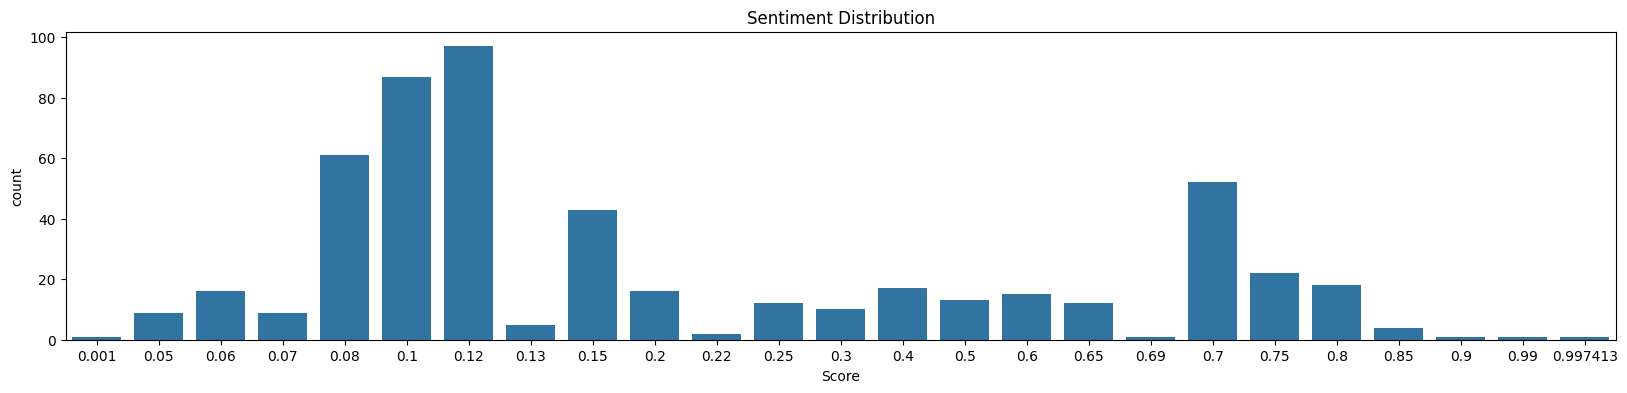

In [77]:
# Show sentiment distribution
plt.figure(figsize=(20,4))
sns.countplot(x='Score', data=df)
plt.title('Sentiment Distribution')
plt.show()

## Categorization of Reviews Based on Sentiment

After reviewing the translated dataset, I observed three distinct types of reviews:

1. **Positive Reviews**  
   In this type, the review focuses entirely on the positive aspects of the movie. The review highlights the strengths and praises the movie without mentioning any negatives.
   - **Example**:  
     _"The visual effects and animation are truly amazing. I'm thoroughly impressed!"_  
     **Score**: 0.08

2. **Negative Reviews**  
   These reviews are dominated by negative opinions. The reviewer highlights all the drawbacks and criticizes the movie, often leaving little to no room for praise.
   - **Example**:  
     _"Avengers: Endgame is disappointing and too cliched."_  
     **Score**: 0.9

3. **Neutral Reviews**  
   These reviews are more balanced, where both positive and negative aspects of the movie are discussed. They present a mixed opinion, offering a nuanced view of the film.
   - **Example**:  
     _"While Avengers: Endgame provides closure to some storylines, certain character arcs feel underdeveloped. The film, however, compensates with epic battles and stunning visuals. A rollercoaster of emotions that serves as a fitting end to an era of superheroes."_  
     **Score**: 0.4

### Sentiment Score Interpretation:
- **Lower Scores (Closer to 0)**: These reviews are generally **positive**, indicating that the reviewer had a favorable opinion of the movie.
- **Higher Scores (Closer to 1)**: These reviews tend to be **negative**, indicating dissatisfaction or disappointment with the movie.


In [82]:
# Filter the dataframe based on the Score range
df_filtered = df[(df['Score'] >= 0.4) & (df['Score'] <= 0.6)]

# Display only the 'Review_English' and 'Score' columns
df_filtered[['Review_English', 'Score']]


,Review_English,Score
6,Excessive and shocking action scenes.Sometimes...,0.4
17,Action scenes are too dramatic and excessive.U...,0.6
22,Visual Effects is great but the plot is less a...,0.6
34,Excessive action scenes.There are too many spe...,0.6
65,The thrilling action but the plot was a bit we...,0.5
101,Action scenes are too many and sometimes unnec...,0.4
112,Dramatic and effective action scenes.There are...,0.6
172,Excessive and unnecessary action scenes.Someti...,0.4
183,Dramatic and effective action scenes.There are...,0.6
210,"Too many action scenes, sometimes unnecessary....",0.4


## Hence i decided to use between 3 classifiers, negative, neutral and postive, the range being less than 0.4=postive, 0.4-0.6=neutrel and 0.6 and more being negative

In [22]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import random
from collections import Counter
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

def set_random_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    
set_random_seeds(42)



## 2. Text Preprocessing Class
Handles language filtering, sentiment labeling, and text cleaning for English and Malay reviews.


# Summary of MovieReviewPreprocessor Class

The `MovieReviewPreprocessor` class is designed for cleaning and processing movie reviews for sentiment analysis. It performs the following tasks:

### 1. **Language Filtering**:
   - It filters reviews to keep only English and Malay texts.

### 2. **Sentiment Labeling**:
   - It classifies reviews into three sentiment categories based on the score:
     - **Good (1)**: Score < 0.4
     - **Neutral (2)**: 0.4 <= Score <= 0.6
     - **Bad (3)**: Score > 0.6

### 3. **Text Cleaning**:
   - The reviews are cleaned by:
     - Lowercasing the text
     - Expanding English contractions
     - Removing URLs, HTML tags, and special characters
     - Normalizing whitespace

### 4. **Text Preprocessing**:
   - The cleaned text is:
     - Tokenized
     - Stopwords are removed (while preserving sentiment-related words)
     - Words are lemmatized (for English)
     - Short tokens and numbers are also removed

This class prepares the movie review data by transforming it into a format suitable for further analysis or machine learning tasks.


In [23]:
class MovieReviewPreprocessor:
    def __init__(self, random_seed=42):
        self.random_seed = random_seed
        self.lemmatizer = WordNetLemmatizer()
        self.english_stopwords = set(stopwords.words('english'))
        self.malay_stopwords = {
            'dan', 'atau', 'ini', 'itu', 'yang', 'di', 'ke', 'dari', 'untuk',
            'dengan', 'pada', 'dalam', 'oleh', 'adalah', 'akan', 'telah',
            'sudah', 'sedang', 'bisa', 'dapat', 'harus', 'mesti', 'boleh'
        }
        self.contractions = {
            "don't": "do not", "won't": "will not", "can't": "cannot",
            "n't": " not", "'re": " are", "'ve": " have", "'ll": " will",
            "'d": " would", "'m": " am", "it's": "it is"
        }
    
    def filter_languages(self, df):
        filtered_df = df[df['Language'].isin(['English', 'Malay'])].copy()
        print(f"Filtered: {len(df)} -> {len(filtered_df)} samples")
        return filtered_df
    
    def create_sentiment_labels(self, df):
        def score_to_sentiment(score):
            if score < 0.4:
                return 1  # good
            elif score <= 0.6:
                return 2  # neutral
            else:
                return 3  # bad
        
        df['sentiment'] = df['Score'].apply(score_to_sentiment)
        sentiment_counts = df['sentiment'].value_counts().sort_index()
        print(f"Sentiment distribution: {dict(sentiment_counts)}")
        return df
    
    def clean_text(self, text, language='English'):
        text = text.lower()
        if language == 'English':
            for contraction, expansion in self.contractions.items():
                text = re.sub(re.escape(contraction), expansion, text, flags=re.IGNORECASE)
        
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'<.*?>', '', text)
        text = re.sub(r'[^\w\s!?.,-]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    
    def preprocess_text(self, text, language='English'):
        text = self.clean_text(text, language)
        tokens = word_tokenize(text)
        
        if language == 'English':
            stopwords_set = self.english_stopwords - {'not', 'no', 'never', 'very', 'really'}
        else:
            stopwords_set = self.malay_stopwords
        
        tokens = [token for token in tokens if token not in stopwords_set]
        
        if language == 'English':
            tokens = [self.lemmatizer.lemmatize(token) for token in tokens]
        
        tokens = [token for token in tokens if len(token) > 2 and not token.isdigit()]
        return tokens

## 3. Data Augmentation Techniques
Functions for text augmentation including synonym replacement, word swapping, deletion, and insertion.

### Summary of Data Augmentation Functions

This code defines several data augmentation techniques for text data. These methods are used to modify a list of tokens (words) in a review to create new variations, which helps improve the robustness of a machine learning model. The functions are:

1. **get_synonyms(word)**:
   - Fetches synonyms for a given word using WordNet and returns them as a sorted list, excluding the original word.

2. **synonym_replacement(tokens, n_replacements=1, random_state=42)**:
   - Replaces a specified number of random tokens in the list with their synonyms. The number of replacements can be adjusted.

3. **random_swap(tokens, n_swaps=1, random_state=42)**:
   - Randomly swaps a specified number of token pairs in the list to generate new variations.

4. **random_deletion(tokens, p=0.1, random_state=42)**:
   - Randomly deletes words from the token list based on a specified probability. If all words are deleted, one word is randomly chosen to remain.

5. **random_insertion(tokens, n_insertions=1, random_state=42)**:
   - Inserts a specified number of random synonyms of words in the token list at random positions.

These techniques are commonly used to augment text data by creating variations of the input data, helping to increase the model's generalization ability and improve performance.


In [ ]:
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name().replace('_', ' '))
    synonyms.discard(word)
    return sorted(list(synonyms))

def synonym_replacement(tokens, n_replacements=1, random_state=42):
    local_random = random.Random(random_state)
    new_tokens = tokens.copy()
    if len(tokens) == 0:
        return new_tokens
    
    random_indices = local_random.sample(range(len(tokens)), min(n_replacements, len(tokens)))
    for idx in random_indices:
        synonyms = get_synonyms(tokens[idx])
        if synonyms:
            new_tokens[idx] = local_random.choice(synonyms)
    return new_tokens

def random_swap(tokens, n_swaps=1, random_state=42):
    local_random = random.Random(random_state)
    new_tokens = tokens.copy()
    for _ in range(n_swaps):
        if len(new_tokens) < 2:
            break
        idx1, idx2 = local_random.sample(range(len(new_tokens)), 2)
        new_tokens[idx1], new_tokens[idx2] = new_tokens[idx2], new_tokens[idx1]
    return new_tokens

def random_deletion(tokens, p=0.1, random_state=42):
    local_random = random.Random(random_state)
    if len(tokens) <= 1:
        return tokens
    
    new_tokens = [token for token in tokens if local_random.random() > p]
    return new_tokens if new_tokens else [local_random.choice(tokens)]

def random_insertion(tokens, n_insertions=1, random_state=42):
    local_random = random.Random(random_state)
    new_tokens = tokens.copy()
    for _ in range(n_insertions):
        if len(tokens) == 0:
            break
        random_word = local_random.choice(tokens)
        synonyms = get_synonyms(random_word)
        if synonyms:
            random_synonym = local_random.choice(synonyms)
            random_idx = local_random.randint(0, len(new_tokens))
            new_tokens.insert(random_idx, random_synonym)
    return new_tokens


## 4. Data Splitting and Balancing
Handles train/val/test splitting and balancing with augmentation only on training data.

### Summary of Functions

1. **`split_data_no_leakage`**:
    - This function splits the dataset into training, validation, and test sets, ensuring there is **no data leakage**.
    - It first splits the data into training and temporary (validation + test) sets. Then it further splits the temporary data into validation and test sets.
    - The function ensures that the splits are **stratified** based on the sentiment label, maintaining the distribution of sentiments across the splits.

2. **`smart_rebalance_val_test`**:
    - This function **rebalance** the validation and test sets by ensuring that both sets have at least a specified number of samples for each sentiment class.
    - It combines the validation and test data, samples the minimum required number of samples per sentiment class for the test set, and moves the rest to the validation set.
    - The function ensures that the **test set** is balanced with respect to the sentiment classes, while the **validation set** remains natural (no data leakage from the test set).

3. **`balance_train_with_augmentation`**:
    - This function handles **data augmentation** for the training set to ensure balanced sentiment classes.
    - It checks if any sentiment class in the training set is underrepresented and applies various augmentation techniques (such as **synonym replacement**, **random swapping**, **random deletion**, and **random insertion**) to generate additional samples for those underrepresented classes.
    - The function guarantees that the **final training set** is balanced across sentiment classes, providing an equal representation of each class to avoid bias during model training.

These functions collectively ensure that the dataset is **balanced** and **free of data leakage**, while also utilizing data augmentation to improve the training process.


In [24]:
def split_data_no_leakage(df, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, random_seed=42):
    temp_ratio = val_ratio + test_ratio
    X_train, X_temp, y_train, y_temp = train_test_split(
        df.drop(['sentiment'], axis=1), df['sentiment'], 
        test_size=temp_ratio, random_state=random_seed, stratify=df['sentiment']
    )
    
    test_ratio_adjusted = test_ratio / temp_ratio
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=test_ratio_adjusted, 
        random_state=random_seed, stratify=y_temp
    )
    
    train_df = X_train.copy()
    train_df['sentiment'] = y_train
    val_df = X_val.copy()
    val_df['sentiment'] = y_val
    test_df = X_test.copy()
    test_df['sentiment'] = y_test
    
    print(f"Split: Train {len(train_df)}, Val {len(val_df)}, Test {len(test_df)}")
    return train_df, val_df, test_df

def smart_rebalance_val_test(val_df, test_df, min_test_samples_per_class=20, random_seed=42):
    combined_df = pd.concat([val_df, test_df], ignore_index=True)
    class_counts = combined_df['sentiment'].value_counts().sort_index()
    actual_test_size = min(min_test_samples_per_class, min(class_counts))
    
    new_test_samples = []
    remaining_samples = []
    
    for sentiment in [1, 2, 3]:
        sentiment_samples = combined_df[combined_df['sentiment'] == sentiment]
        test_samples = sentiment_samples.sample(n=actual_test_size, random_state=random_seed)
        new_test_samples.append(test_samples)
        
        remaining_indices = sentiment_samples.index.difference(test_samples.index)
        remaining_samples.append(sentiment_samples.loc[remaining_indices])
    
    new_test_df = pd.concat(new_test_samples, ignore_index=True).sample(frac=1, random_state=random_seed).reset_index(drop=True)
    new_val_df = pd.concat(remaining_samples, ignore_index=True).sample(frac=1, random_state=random_seed).reset_index(drop=True)
    
    print(f"Rebalanced: Test {len(new_test_df)}, Val {len(new_val_df)}")
    return new_val_df, new_test_df

def balance_train_with_augmentation(preprocessor, train_df, target_samples_per_class=None, random_seed=42):
    class_counts = train_df['sentiment'].value_counts().sort_index()
    if target_samples_per_class is None:
        target_samples_per_class = class_counts.max()
    
    balanced_data = []
    
    for sentiment in [1, 2, 3]:
        class_df = train_df[train_df['sentiment'] == sentiment].copy()
        current_count = len(class_df)
        
        # Add original samples
        for _, row in class_df.iterrows():
            row_dict = row.to_dict()
            row_dict['augmented'] = False
            balanced_data.append(row_dict)
        
        # Add augmented samples if needed
        if current_count < target_samples_per_class:
            needed_samples = target_samples_per_class - current_count
            valid_rows = class_df[class_df['tokens'].apply(lambda x: len(x) > 0)]
            
            techniques = ['synonym', 'swap', 'deletion', 'insertion']
            samples_generated = 0
            
            for attempt in range(needed_samples * 10):
                if samples_generated >= needed_samples:
                    break
                
                source_idx = attempt % len(valid_rows)
                technique = techniques[attempt % len(techniques)]
                aug_seed = random_seed + attempt
                
                source_row = valid_rows.iloc[source_idx]
                tokens = source_row['tokens']
                
                try:
                    if technique == 'synonym':
                        new_tokens = synonym_replacement(tokens, max(1, len(tokens) // 6), aug_seed)
                    elif technique == 'swap':
                        new_tokens = random_swap(tokens, max(1, len(tokens) // 10), aug_seed)
                    elif technique == 'deletion':
                        new_tokens = random_deletion(tokens, p=0.15, random_state=aug_seed)
                    else:  # insertion
                        new_tokens = random_insertion(tokens, max(1, len(tokens) // 8), aug_seed)
                    
                    if (len(new_tokens) > 2 and new_tokens != tokens and 
                        len(new_tokens) >= len(tokens) * 0.7):
                        
                        augmented_row = source_row.copy()
                        augmented_row['tokens'] = new_tokens
                        augmented_row['processed_review'] = ' '.join(new_tokens)
                        augmented_row['augmented'] = True
                        balanced_data.append(augmented_row.to_dict())
                        samples_generated += 1
                except:
                    continue
    
    balanced_train_df = pd.DataFrame(balanced_data)
    print(f"Balanced training: {len(train_df)} -> {len(balanced_train_df)} samples")
    return balanced_train_df

## 5. Vocabulary Creation and Sequence Preparation
Creates vocabulary from training data and converts text to numerical sequences for neural networks.

### Summary of Functions

1. **`create_vocabulary`**:
    - This function **creates a vocabulary** from the training dataset based on the tokens in the 'tokens' column of `train_df`.
    - It counts the frequency of each token and **filters out tokens that appear less than `min_freq` times**.
    - The vocabulary is then sorted by token frequency, and only the **top `max_vocab_size` tokens** are kept.
    - Two dictionaries are created: `vocab_to_idx`, which maps each token to an index, and `idx_to_vocab`, which maps an index to a token.
    - The function returns the **vocabulary dictionaries** and prints the vocabulary size.

2. **`prepare_sequences_for_rnn`**:
    - This function **prepares sequences** for input into an RNN model.
    - It iterates over the dataset, converting each token in the 'tokens' column into its corresponding index from `vocab_to_idx`.
    - If a token is not found in the vocabulary, it is assigned the **<UNK>** index (for unknown tokens).
    - The sequences are **padded or truncated** to the `max_length` to ensure uniform length.
    - It also converts sentiment labels to a 0-2 range (for 3-class sentiment classification) and returns the prepared sequences and labels as numpy arrays.

These functions are used to **prepare the dataset** for training a neural network by creating a vocabulary and converting the text data into numerical sequences suitable for input into an RNN.


In [25]:
def create_vocabulary(train_df, min_freq=2, max_vocab_size=10000):
    all_tokens = []
    for tokens in train_df['tokens']:
        all_tokens.extend(tokens)
    
    token_counts = Counter(all_tokens)
    filtered_tokens = {token: count for token, count in token_counts.items() if count >= min_freq}
    most_common = sorted(filtered_tokens.items(), key=lambda x: (-x[1], x[0]))[:max_vocab_size]
    
    vocab_to_idx = {'<PAD>': 0, '<UNK>': 1}
    idx_to_vocab = {0: '<PAD>', 1: '<UNK>'}
    
    for idx, (token, count) in enumerate(most_common, start=2):
        vocab_to_idx[token] = idx
        idx_to_vocab[idx] = token
    
    print(f"Vocabulary size: {len(vocab_to_idx)}")
    return vocab_to_idx, idx_to_vocab

def prepare_sequences_for_rnn(df, vocab_to_idx, max_length=100):
    sequences = []
    labels = []
    
    for _, row in df.iterrows():
        tokens = row['tokens']
        sentiment = row['sentiment']
        
        sequence = []
        for token in tokens:
            if token in vocab_to_idx:
                sequence.append(vocab_to_idx[token])
            else:
                sequence.append(vocab_to_idx['<UNK>'])
        
        if len(sequence) > max_length:
            sequence = sequence[:max_length]
        else:
            sequence = sequence + [vocab_to_idx['<PAD>']] * (max_length - len(sequence))
        
        sequences.append(sequence)
        labels.append(sentiment - 1)  # Convert to 0-2
    
    return np.array(sequences), np.array(labels)

## 6. Main Preprocessing Pipeline
Complete preprocessing function that orchestrates all steps while preventing data leakage.

In [26]:
def preprocess_movie_reviews_no_leakage(df, target_samples_per_class=None, random_seed=42,
                                      train_ratio=0.7, val_ratio=0.15, test_ratio=0.15,
                                      balance_test=True, min_test_samples_per_class=20):
    
    set_random_seeds(random_seed)
    print("Starting preprocessing pipeline...")
    
    # Initialize preprocessor
    preprocessor = MovieReviewPreprocessor(random_seed=random_seed)
    
    # Filter languages and create labels
    df = preprocessor.filter_languages(df)
    df = preprocessor.create_sentiment_labels(df)
    
    # Preprocess text
    processed_reviews = []
    processed_tokens_list = []
    
    for idx, row in df.iterrows():
        tokens = preprocessor.preprocess_text(row['Review'], row['Language'])
        processed_reviews.append(' '.join(tokens))
        processed_tokens_list.append(tokens)
    
    df['processed_review'] = processed_reviews
    df['tokens'] = processed_tokens_list
    print("Text preprocessing completed")
    
    # Split data before augmentation
    train_df, val_df, test_df = split_data_no_leakage(df, train_ratio, val_ratio, test_ratio, random_seed)
    
    # Balance training set with augmentation
    train_balanced_df = balance_train_with_augmentation(preprocessor, train_df, target_samples_per_class, random_seed)
    
    # Smart rebalance val/test if requested
    if balance_test:
        val_df, test_df = smart_rebalance_val_test(val_df, test_df, min_test_samples_per_class, random_seed)
    
    # Create vocabulary and prepare sequences
    vocab_to_idx, idx_to_vocab = create_vocabulary(train_balanced_df)
    
    X_train, y_train = prepare_sequences_for_rnn(train_balanced_df, vocab_to_idx)
    X_val, y_val = prepare_sequences_for_rnn(val_df, vocab_to_idx)
    X_test, y_test = prepare_sequences_for_rnn(test_df, vocab_to_idx)
    
    # Convert to categorical
    y_train_cat = to_categorical(y_train, num_classes=3)
    y_val_cat = to_categorical(y_val, num_classes=3)
    y_test_cat = to_categorical(y_test, num_classes=3)
    
    print("Preprocessing complete!")
    print(f"Final shapes - Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
    
    return {
        'dataframes': {'train': train_balanced_df, 'val': val_df, 'test': test_df},
        'vocabulary': {'vocab_to_idx': vocab_to_idx, 'idx_to_vocab': idx_to_vocab},
        'sequences': {
            'X_train': X_train, 'X_val': X_val, 'X_test': X_test,
            'y_train': y_train_cat, 'y_val': y_val_cat, 'y_test': y_test_cat
        },
        'config': {
            'balance_test': balance_test, 'min_test_samples_per_class': min_test_samples_per_class,
            'random_seed': random_seed, 'target_samples_per_class': target_samples_per_class
        }
    }

## 7. Execute Preprocessing
Run the complete preprocessing pipeline on the movie reviews dataset.

In [83]:
# Load and preprocess data

results = preprocess_movie_reviews_no_leakage(
    df, 
    target_samples_per_class=500,
    random_seed=42,
    balance_test=True
)

print("Data preprocessing completed successfully!")

Starting preprocessing pipeline...
Filtered: 401 -> 399 samples
Original sentiment distribution: {1: 280, 2: 37, 3: 82}
Text preprocessing completed
Split: Train 279, Val 60, Test 60

Balancing training set with augmentation...
----------------------------------------
Training set before balancing: {1: 196, 2: 26, 3: 57}
Target samples per class: 500
Processing Good: 196 → 500
Processing Neutral: 26 → 500
Processing Bad: 57 → 500
Training set after balancing: {1: 500, 2: 500, 3: 500}
Training set size: 279 → 1500
Rebalanced: Test 33, Val 87
Vocabulary size (from training only): 816
Preprocessing complete!
Final shapes - Train: (1500, 100), Val: (87, 100), Test: (33, 100)
Data preprocessing completed successfully!


### Summary of the Code

This code trains and evaluates multiple Recurrent Neural Network (RNN)-based models (RNN, LSTM, GRU, BiRNN) for sentiment classification on movie reviews. The key steps are:

1. **Data Preparation**:
   - It extracts the training (`X_train`, `y_train`), validation (`X_val`, `y_val`), and test (`X_test`, `y_test`) datasets.
   - The vocabulary size is calculated from the training data.

2. **Model Creation**:
   - It defines a `create_model` function to build different types of models (RNN, LSTM, GRU, BiRNN) with an embedding layer followed by the respective RNN layer (SimpleRNN, LSTM, or GRU).
   - The models are compiled with Adam optimizer and categorical crossentropy loss.

3. **Training**:
   - For each model type, the code trains the model with early stopping (monitoring validation loss).
   - The training process is verbose to show the training progress, and early stopping helps prevent overfitting.

4. **Visualization**:
   - The training and validation loss and accuracy curves are plotted using the `plot_training_curves` function.
   - After training, a confusion matrix is generated to evaluate the model's predictions on the test set.

5. **Evaluation**:
   - After training each model, the test loss and accuracy are printed, followed by a detailed classification report and confusion matrix.
   
6. **Model Comparison**:
   - A final summary of test accuracy and loss for each model is displayed in a DataFrame.
   - The model with the highest test accuracy is identified as the best performing model.

7. **Final Visualization**:
   - A bar plot of the test accuracy across all models is generated for comparison.

The code ensures that multiple models are trained, evaluated, and compared for the best performance, with the final results displayed in both numerical and graphical formats.


Training on 366 samples, vocab size: 465
Validation: 119 samples, Test: 39 samples

TRAINING MODEL 1/4: RNN

RNN Model Architecture:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          46500     
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               29312     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 

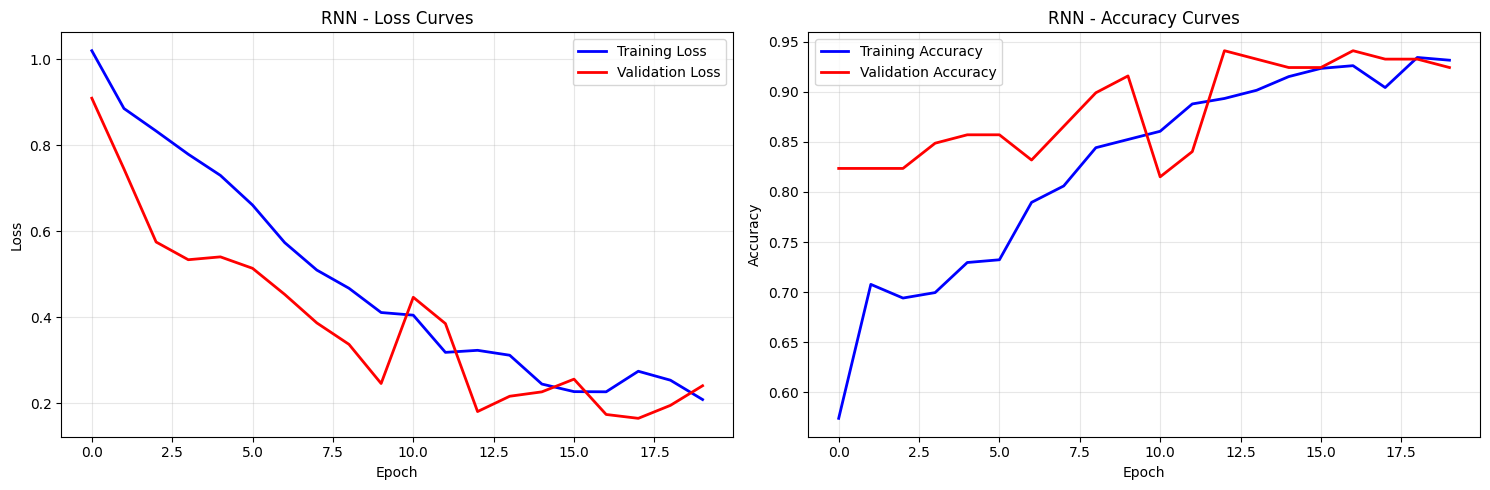

Evaluating RNN on test set...

RNN TEST RESULTS:
----------------------------------------
Test Accuracy: 0.7692
Test Loss: 0.6037

Classification Report:
              precision    recall  f1-score   support

        Good       0.68      1.00      0.81        13
     Neutral       0.90      0.69      0.78        13
         Bad       0.80      0.62      0.70        13

    accuracy                           0.77        39
   macro avg       0.79      0.77      0.76        39
weighted avg       0.79      0.77      0.76        39



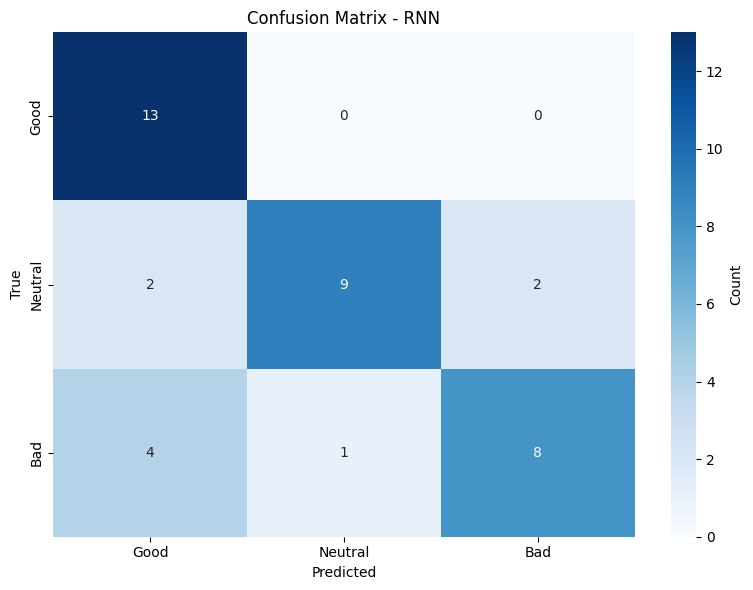


RNN evaluation completed!

TRAINING MODEL 2/4: LSTM

LSTM Model Architecture:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          46500     
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                         

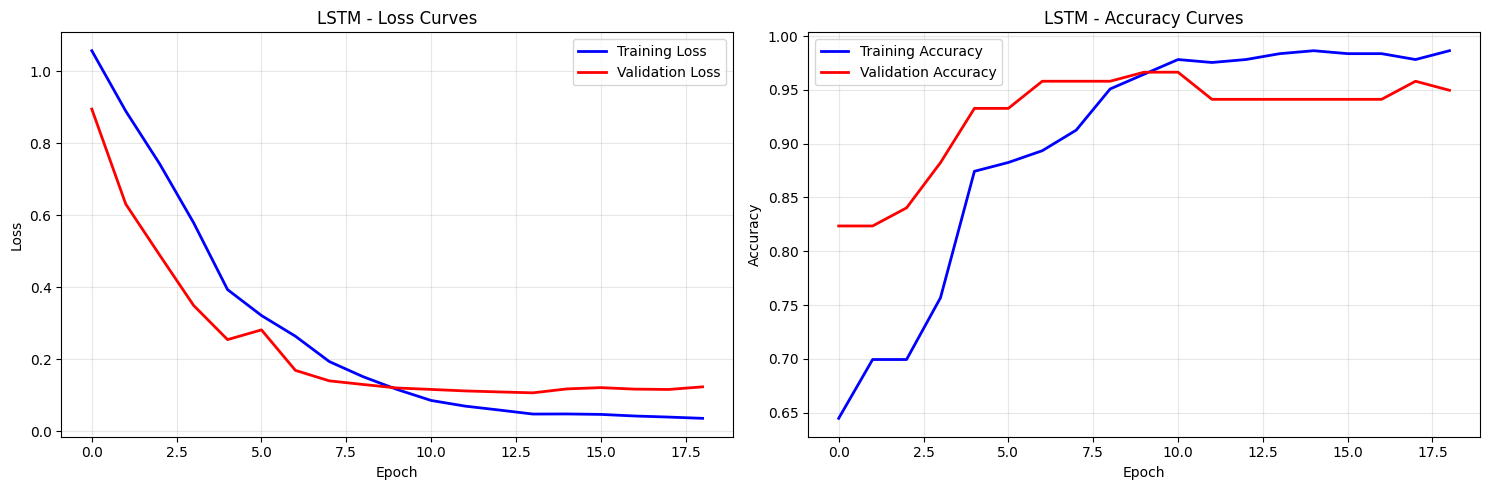

Evaluating LSTM on test set...

LSTM TEST RESULTS:
----------------------------------------
Test Accuracy: 0.8462
Test Loss: 1.2124

Classification Report:
              precision    recall  f1-score   support

        Good       0.76      1.00      0.87        13
     Neutral       0.91      0.77      0.83        13
         Bad       0.91      0.77      0.83        13

    accuracy                           0.85        39
   macro avg       0.86      0.85      0.84        39
weighted avg       0.86      0.85      0.84        39



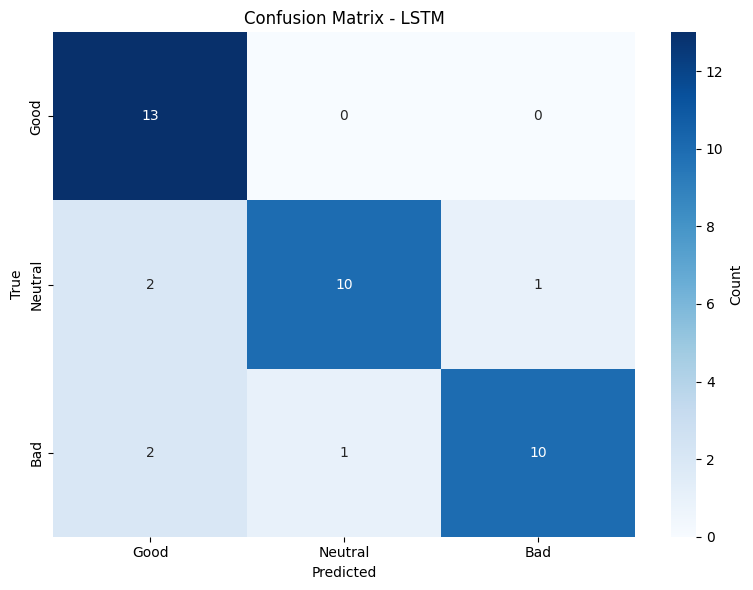


LSTM evaluation completed!

TRAINING MODEL 3/4: GRU

GRU Model Architecture:
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          46500     
                                                                 
 gru (GRU)                   (None, 128)               88320     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 3)                 195       
                                          

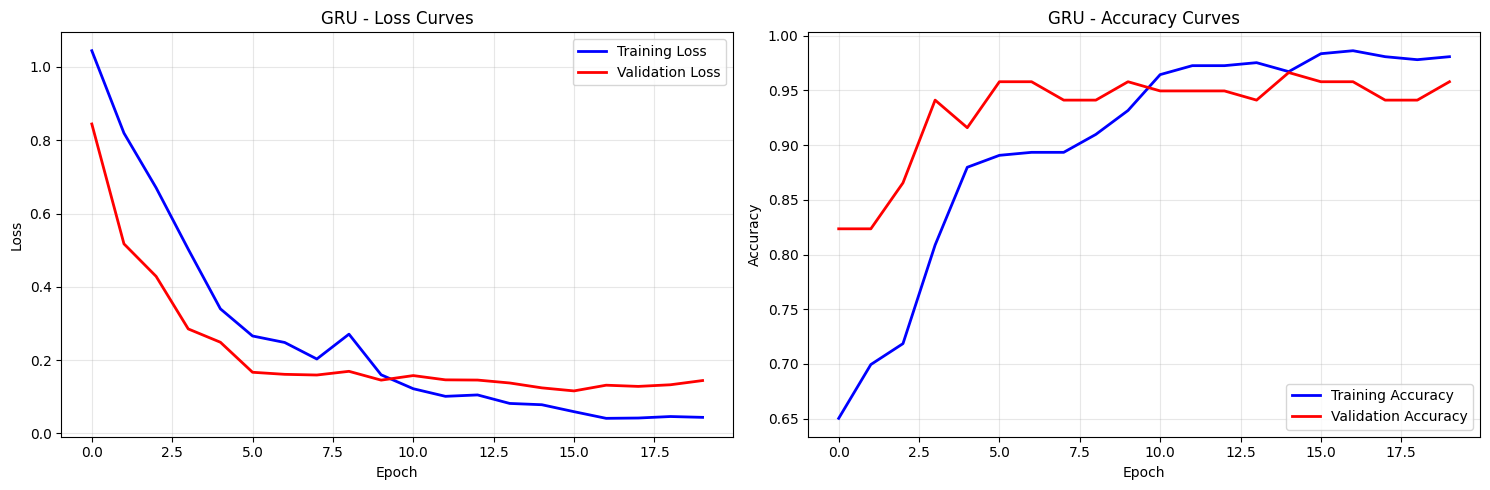

Evaluating GRU on test set...

GRU TEST RESULTS:
----------------------------------------
Test Accuracy: 0.8462
Test Loss: 1.2587

Classification Report:
              precision    recall  f1-score   support

        Good       0.76      1.00      0.87        13
     Neutral       0.91      0.77      0.83        13
         Bad       0.91      0.77      0.83        13

    accuracy                           0.85        39
   macro avg       0.86      0.85      0.84        39
weighted avg       0.86      0.85      0.84        39



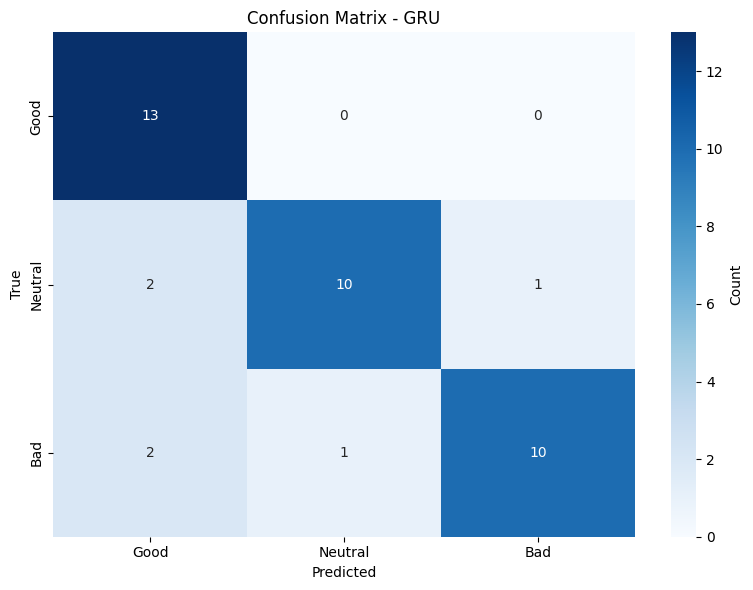


GRU evaluation completed!

TRAINING MODEL 4/4: BiRNN

BiRNN Model Architecture:
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          46500     
                                                                 
 bidirectional (Bidirectiona  (None, 256)              58624     
 l)                                                              
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                16448     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 3) 

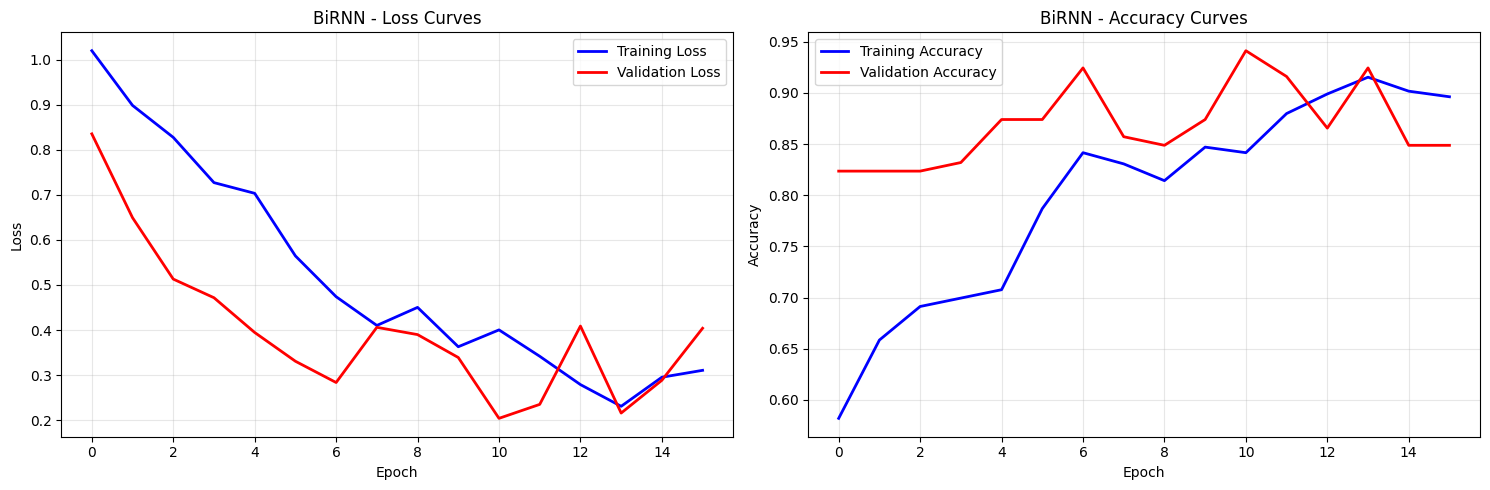

Evaluating BiRNN on test set...

BiRNN TEST RESULTS:
----------------------------------------
Test Accuracy: 0.6410
Test Loss: 0.8284

Classification Report:
              precision    recall  f1-score   support

        Good       0.54      1.00      0.70        13
     Neutral       1.00      0.31      0.47        13
         Bad       0.73      0.62      0.67        13

    accuracy                           0.64        39
   macro avg       0.76      0.64      0.61        39
weighted avg       0.76      0.64      0.61        39



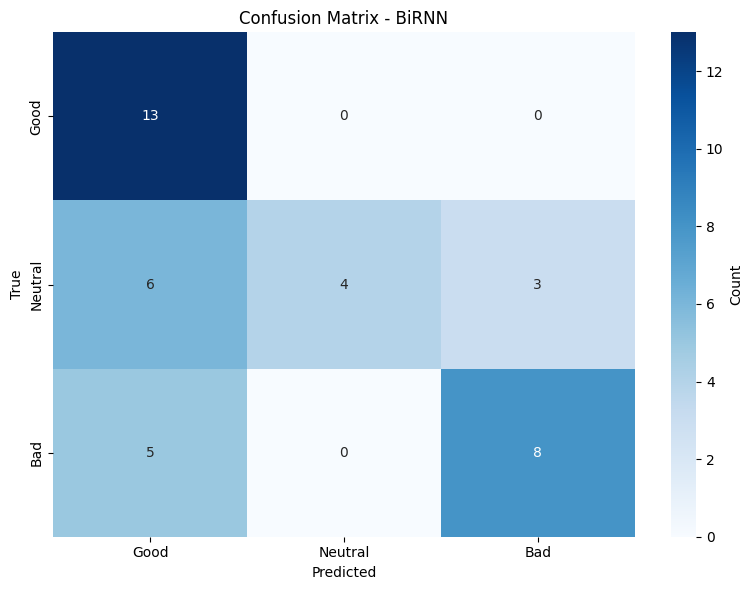


BiRNN evaluation completed!

FINAL COMPARISON OF ALL MODELS

Model Performance Summary:
Model Test Accuracy Test Loss
  RNN        0.7692    0.6037
 LSTM        0.8462    1.2124
  GRU        0.8462    1.2587
BiRNN        0.6410    0.8284

Best Performing Model: LSTM
Best Test Accuracy: 0.8462


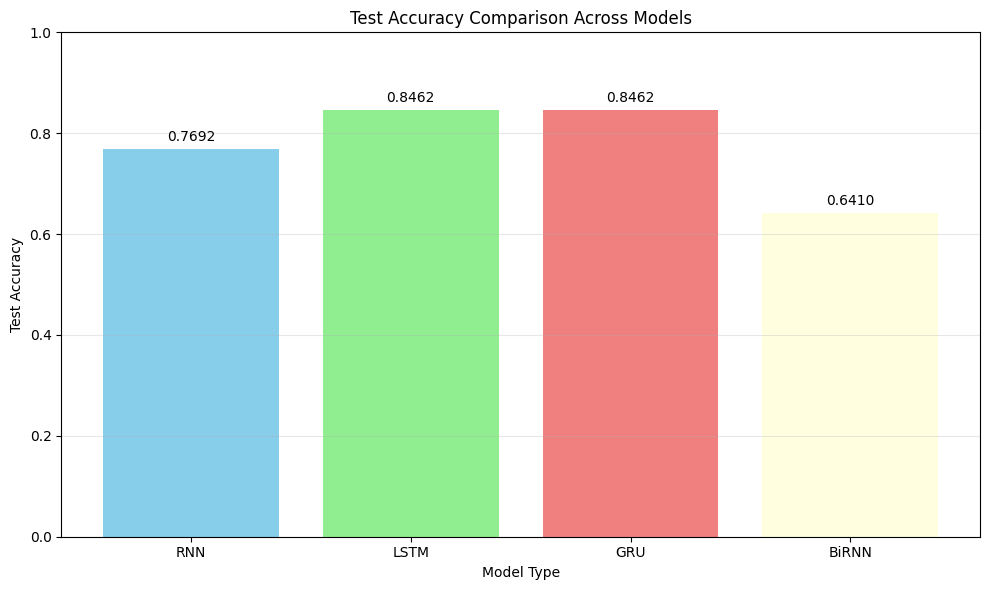


Training and evaluation completed for all 4 models!


In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd

# Extract data
X_train = results['sequences']['X_train']
X_val = results['sequences']['X_val'] 
X_test = results['sequences']['X_test']
y_train = results['sequences']['y_train']
y_val = results['sequences']['y_val']
y_test = results['sequences']['y_test']
vocab_size = len(results['vocabulary']['vocab_to_idx'])

print(f"Training on {X_train.shape[0]} samples, vocab size: {vocab_size}")
print(f"Validation: {X_val.shape[0]} samples, Test: {X_test.shape[0]} samples")
print("="*60)

# Model architectures
def create_model(model_type, vocab_size, max_length=100):
    model = Sequential()
    model.add(Embedding(vocab_size, 100, input_length=max_length, mask_zero=True))
    
    if model_type == 'RNN':
        model.add(SimpleRNN(128, dropout=0.3, recurrent_dropout=0.3))
    elif model_type == 'LSTM':
        model.add(LSTM(128, dropout=0.3, recurrent_dropout=0.3))
    elif model_type == 'GRU':
        model.add(GRU(128, dropout=0.3, recurrent_dropout=0.3))
    elif model_type == 'BiRNN':
        model.add(Bidirectional(SimpleRNN(128, dropout=0.3, recurrent_dropout=0.3)))
    
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def plot_training_curves(history, model_type):
    """Plot training and validation curves for a single model"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss plot
    ax1.plot(history.history['loss'], label='Training Loss', linewidth=2, color='blue')
    ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='red')
    ax1.set_title(f'{model_type} - Loss Curves')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Accuracy plot
    ax2.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, color='blue')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, color='red')
    ax2.set_title(f'{model_type} - Accuracy Curves')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix_and_evaluate(model, X_test, y_test, model_type):
    """Plot confusion matrix and show detailed evaluation metrics"""
    # Predictions
    y_pred = model.predict(X_test, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    # Metrics
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    
    print(f"\n{model_type} TEST RESULTS:")
    print("-" * 40)
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")
    
    # Classification report
    class_names = ['Good', 'Neutral', 'Bad']
    print(f"\nClassification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=class_names))
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {model_type}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()
    
    return {
        'model_type': model_type,
        'test_accuracy': test_acc,
        'test_loss': test_loss
    }

# Train all models with verbose output and individual plotting
models = {}
histories = {}
results_summary = []
model_types = ['RNN', 'LSTM', 'GRU', 'BiRNN']

for i, model_type in enumerate(model_types):
    print(f"\n{'='*60}")
    print(f"TRAINING MODEL {i+1}/4: {model_type}")
    print(f"{'='*60}")
    
    # Create model
    model = create_model(model_type, vocab_size)
    
    # Show model architecture
    print(f"\n{model_type} Model Architecture:")
    model.summary()
    
    # Setup early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
    
    print(f"\nStarting training for {model_type}...")
    print("-" * 40)
    
    # Train model with verbose output
    history = model.fit(X_train, y_train, 
                       validation_data=(X_val, y_val),
                       epochs=20, batch_size=32, 
                       callbacks=[early_stop], 
                       verbose=1)  # Show training progress
    
    # Store model and history
    models[model_type] = model
    histories[model_type] = history
    
    print(f"\n{model_type} training completed!")
    print(f"Total epochs trained: {len(history.history['loss'])}")
    
    # Plot training curves immediately after training
    print(f"\nPlotting training curves for {model_type}...")
    plot_training_curves(history, model_type)
    
    # Evaluate and plot confusion matrix immediately
    print(f"Evaluating {model_type} on test set...")
    model_results = plot_confusion_matrix_and_evaluate(model, X_test, y_test, model_type)
    results_summary.append(model_results)
    
    print(f"\n{model_type} evaluation completed!")
    print("="*60)

# Final summary comparison
print(f"\n{'='*60}")
print("FINAL COMPARISON OF ALL MODELS")
print(f"{'='*60}")

# Create summary DataFrame
summary_data = []
for result in results_summary:
    summary_data.append({
        'Model': result['model_type'],
        'Test Accuracy': f"{result['test_accuracy']:.4f}",
        'Test Loss': f"{result['test_loss']:.4f}"
    })

summary_df = pd.DataFrame(summary_data)
print("\nModel Performance Summary:")
print(summary_df.to_string(index=False))

# Find and announce best model
best_model_name = max(results_summary, key=lambda x: x['test_accuracy'])['model_type']
best_accuracy = max(results_summary, key=lambda x: x['test_accuracy'])['test_accuracy']

print(f"\nBest Performing Model: {best_model_name}")
print(f"Best Test Accuracy: {best_accuracy:.4f}")

# Plot final comparison
plt.figure(figsize=(10, 6))
model_names = [r['model_type'] for r in results_summary]
accuracies = [r['test_accuracy'] for r in results_summary]

bars = plt.bar(model_names, accuracies, color=['skyblue', 'lightgreen', 'lightcoral', 'lightyellow'])
plt.title('Test Accuracy Comparison Across Models')
plt.xlabel('Model Type')
plt.ylabel('Test Accuracy')
plt.ylim(0, 1)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.4f}', ha='center', va='bottom')

plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print(f"\nTraining and evaluation completed for all {len(model_types)} models!")

### Model Performance Evaluation

Based on the performance evaluation, **LSTM** emerged as the best-performing model with the highest test accuracy of 0.8462. The **RNN** model showed the lowest performance with a test accuracy of 0.7692, while the **GRU** and **LSTM** models performed similarly, both achieving an accuracy of 0.8462.

In terms of loss, the **LSTM** model exhibited relatively stable performance compared to others, while the **BiRNN** model had the lowest test accuracy of 0.6410 and the highest test loss, indicating poorer performance on the test set.

### Conclusion
In summary, **LSTM** is the best-performing model among the ones evaluated. The **BiRNN** model, on the other hand, needs improvement based on its performance metrics.

## For all the models the neutral class is performing quite poorly based on all metrics, we would have to fix that

### Code Explanation: Class Weights and Model Training Preparation

This code snippet prepares for model training by calculating class weights, which are crucial for handling imbalanced data, especially when dealing with a "neutral" class in sentiment classification. Here's a breakdown:
ionary.

2. **Vocabulary Size**: It calculates the vocabulary size (`vocab_size`) based on the number of unique tokens in the vocabulary (`vocab_to_idx`).

3. **Class Weight Calculation**:
    - The class labels are extracted from the training labels (`y_train`), converting them from one-hot encoding to class indices using `np.argmax`.
    - The `compute_class_weight` function from `sklearn` calculates the weights for each class in the training data, with the parameter `balanced` ensuring that classes with fewer samples receive a higher weight to mitigate the effect of class imbalance.
    - The calculated weights are stored in `class_weight_dict`, which will be passed during model training to adjust the loss function.

4. **Purpose of Class Weights**: The higher class weight is applied to the "Neutral" class to help the model focus more on those examples and prevent bias towards other classes with more data points.

The class weights are printed out for inspection, ensuring that the model compensates for any class imbalance by applying higher weights to the underrepresented or "struggling" classes.


In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
X_train = results['sequences']['X_train']
X_val = results['sequences']['X_val'] 
X_test = results['sequences']['X_test']
y_train = results['sequences']['y_train']
y_val = results['sequences']['y_val']
y_test = results['sequences']['y_test']
vocab_size = len(results['vocabulary']['vocab_to_idx'])

# Calculate class weights to help with neutral class
y_train_labels = np.argmax(y_train, axis=1)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weight_dict = dict(enumerate(class_weights))
print(f"Class weights: {class_weight_dict}")
print("Higher weight on struggling classes (especially Neutral)")



Class weights: {0: 1.0, 1: 1.0, 2: 1.0}
Higher weight on struggling classes (especially Neutral)


### LSTM Hyperparameter Tuning

This function performs hyperparameter tuning for an LSTM model, testing different combinations of `units`, `dropout`, `dense_units`, and `learning_rate`. It calculates class weights to handle class imbalance, then trains and evaluates each model combination using training, validation, and test data. The best-performing model, based on validation accuracy, is selected and returned, along with the optimal hyperparameters and performance results for each trial.


In [41]:
def create_lstm_model(units=128, dropout=0.3, dense_units=64, learning_rate=0.001):
    """Create LSTM model with specific parameters"""
    model = Sequential([
        Embedding(vocab_size, 100, input_length=100, mask_zero=True),
        LSTM(units, dropout=dropout, recurrent_dropout=dropout),
        Dropout(dropout),
        Dense(dense_units, activation='relu'),
        Dropout(dropout),
        Dense(3, activation='softmax')
    ])
    
    from tensorflow.keras.optimizers import Adam
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

def tune_lstm():
    """Simple LSTM hyperparameter tuning"""
    print("\n" + "="*50)
    print("LSTM HYPERPARAMETER TUNING")
    print("="*50)
    
    # Calculate class weights
    y_train_labels = np.argmax(y_train, axis=1)
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
    class_weight_dict = dict(enumerate(class_weights))
    print(f"Using class weights: {class_weight_dict}")
    
    # Parameter combinations to test
    param_combinations = [
        {'units': 64, 'dropout': 0.2, 'dense_units': 32, 'learning_rate': 0.001},
        {'units': 128, 'dropout': 0.3, 'dense_units': 64, 'learning_rate': 0.001},
        {'units': 256, 'dropout': 0.3, 'dense_units': 64, 'learning_rate': 0.001},
        {'units': 128, 'dropout': 0.4, 'dense_units': 64, 'learning_rate': 0.001},
        {'units': 128, 'dropout': 0.3, 'dense_units': 128, 'learning_rate': 0.001},
        {'units': 128, 'dropout': 0.3, 'dense_units': 64, 'learning_rate': 0.0005},
    ]
    
    best_val_acc = 0
    best_params = None
    best_model = None
    results = []
    
    for i, params in enumerate(param_combinations):
        print(f"\nLSTM Trial {i+1}/{len(param_combinations)}: {params}")
        
        # Create and train model
        model = create_lstm_model(**params)
        early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True, verbose=0)
        
        # Train with class weights
        history = model.fit(X_train, y_train,
                           validation_data=(X_val, y_val),
                           epochs=15, batch_size=32,
                           class_weight=class_weight_dict,
                           callbacks=[early_stop], verbose=0)
        
        # Evaluate
        val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
        test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
        
        print(f"Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")
        
        results.append({
            'params': params,
            'val_acc': val_acc,
            'test_acc': test_acc,
            'model': model
        })
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_params = params
            best_model = model
            print(f" New best LSTM: {val_acc:.4f}")
    
    return best_model, best_params, best_val_acc, results


### GRU Hyperparameter Tuning

This function performs hyperparameter tuning for a GRU model by testing various combinations of `units`, `dropout`, `dense_units`, and `learning_rate`. It calculates class weights to handle class imbalance and trains each model with the given parameters, using validation and test data for evaluation. The best model, based on validation accuracy, is selected, and the results, along with optimal parameters, are returned.


In [43]:
def create_gru_model(units=128, dropout=0.3, dense_units=64, learning_rate=0.001):
    """Create GRU model with specific parameters"""
    model = Sequential([
        Embedding(vocab_size, 100, input_length=100, mask_zero=True),
        GRU(units, dropout=dropout, recurrent_dropout=dropout),
        Dropout(dropout),
        Dense(dense_units, activation='relu'),
        Dropout(dropout),
        Dense(3, activation='softmax')
    ])
    
    from tensorflow.keras.optimizers import Adam
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

def tune_gru():
    """Simple GRU hyperparameter tuning"""
    print("\n" + "="*50)
    print("GRU HYPERPARAMETER TUNING")
    print("="*50)
    
    # Calculate class weights
    y_train_labels = np.argmax(y_train, axis=1)
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
    class_weight_dict = dict(enumerate(class_weights))
    print(f"Using class weights: {class_weight_dict}")
    
    # Parameter combinations to test
    param_combinations = [
        {'units': 64, 'dropout': 0.2, 'dense_units': 32, 'learning_rate': 0.001},
        {'units': 128, 'dropout': 0.3, 'dense_units': 64, 'learning_rate': 0.001},
        {'units': 256, 'dropout': 0.3, 'dense_units': 64, 'learning_rate': 0.001},
        {'units': 128, 'dropout': 0.4, 'dense_units': 64, 'learning_rate': 0.001},
        {'units': 128, 'dropout': 0.3, 'dense_units': 128, 'learning_rate': 0.001},
        {'units': 128, 'dropout': 0.3, 'dense_units': 64, 'learning_rate': 0.0005},
    ]
    
    best_val_acc = 0
    best_params = None
    best_model = None
    results = []
    
    for i, params in enumerate(param_combinations):
        print(f"\nGRU Trial {i+1}/{len(param_combinations)}: {params}")
        
        # Create and train model
        model = create_gru_model(**params)
        early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True, verbose=0)
        
        # Train with class weights
        history = model.fit(X_train, y_train,
                           validation_data=(X_val, y_val),
                           epochs=15, batch_size=32,
                           class_weight=class_weight_dict,
                           callbacks=[early_stop], verbose=0)
        
        # Evaluate
        val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
        test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
        
        print(f"Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")
        
        results.append({
            'params': params,
            'val_acc': val_acc,
            'test_acc': test_acc,
            'model': model
        })
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_params = params
            best_model = model
            print(f"= New best GRU: {val_acc:.4f}")
    
    return best_model, best_params, best_val_acc, results


### Detailed Evaluation with Confusion Matrix

This function evaluates the model on the test set, providing metrics such as test accuracy and test loss. It generates a classification report and a confusion matrix to visually assess the model's performance across different sentiment categories ('Good', 'Neutral', 'Bad'). The function returns the test accuracy after performing these evaluations.


In [44]:
def detailed_evaluation(model, model_name, params):
    """Detailed evaluation with confusion matrix"""
    print(f"\n" + "="*50)
    print(f"FINAL EVALUATION: {model_name}")
    print("="*50)
    print(f"Best parameters: {params}")
    
    # Test predictions
    y_pred = model.predict(X_test, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    # Metrics
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"\nTest Accuracy: {test_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")
    
    # Classification report
    class_names = ['Good', 'Neutral', 'Bad']
    print(f"\nClassification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=class_names))
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Tuned {model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()
    
    return test_acc

### Tuning and Model Comparison

This code begins by tuning the LSTM and GRU models using the `tune_lstm()` and `tune_gru()` functions. It then compares the performance of the baseline model (with a test accuracy of 0.8462) to the tuned models. The performance difference (Δ) between the baseline and tuned models for both LSTM and GRU is calculated and displayed.

After the comparison, the best-performing model is evaluated in detail using the `detailed_evaluation()` function, and the model with the highest test accuracy is declared the winner. The winning model is saved for future use. 


Starting LSTM tuning...

LSTM HYPERPARAMETER TUNING
Using class weights: {0: 0.4765625, 1: 3.8125, 2: 1.564102564102564}

LSTM Trial 1/6: {'units': 64, 'dropout': 0.2, 'dense_units': 32, 'learning_rate': 0.001}
Val Acc: 0.8908, Test Acc: 0.7179
 New best LSTM: 0.8908

LSTM Trial 2/6: {'units': 128, 'dropout': 0.3, 'dense_units': 64, 'learning_rate': 0.001}
Val Acc: 0.9160, Test Acc: 0.8462
 New best LSTM: 0.9160

LSTM Trial 3/6: {'units': 256, 'dropout': 0.3, 'dense_units': 64, 'learning_rate': 0.001}
Val Acc: 0.9412, Test Acc: 0.7692
 New best LSTM: 0.9412

LSTM Trial 4/6: {'units': 128, 'dropout': 0.4, 'dense_units': 64, 'learning_rate': 0.001}
Val Acc: 0.9496, Test Acc: 0.7692
 New best LSTM: 0.9496

LSTM Trial 5/6: {'units': 128, 'dropout': 0.3, 'dense_units': 128, 'learning_rate': 0.001}
Val Acc: 0.9412, Test Acc: 0.5641

LSTM Trial 6/6: {'units': 128, 'dropout': 0.3, 'dense_units': 64, 'learning_rate': 0.0005}
Val Acc: 0.9412, Test Acc: 0.7179
Starting GRU tuning...

GRU HYPERPAR

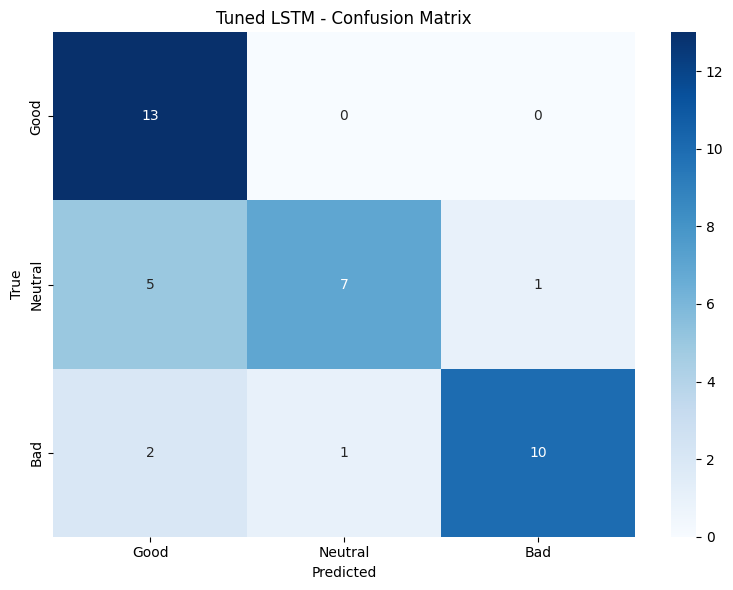


FINAL EVALUATION: GRU
Best parameters: {'units': 128, 'dropout': 0.4, 'dense_units': 64, 'learning_rate': 0.001}

Test Accuracy: 0.8205
Test Loss: 0.5712

Classification Report:
              precision    recall  f1-score   support

        Good       0.72      1.00      0.84        13
     Neutral       0.91      0.77      0.83        13
         Bad       0.90      0.69      0.78        13

    accuracy                           0.82        39
   macro avg       0.84      0.82      0.82        39
weighted avg       0.84      0.82      0.82        39



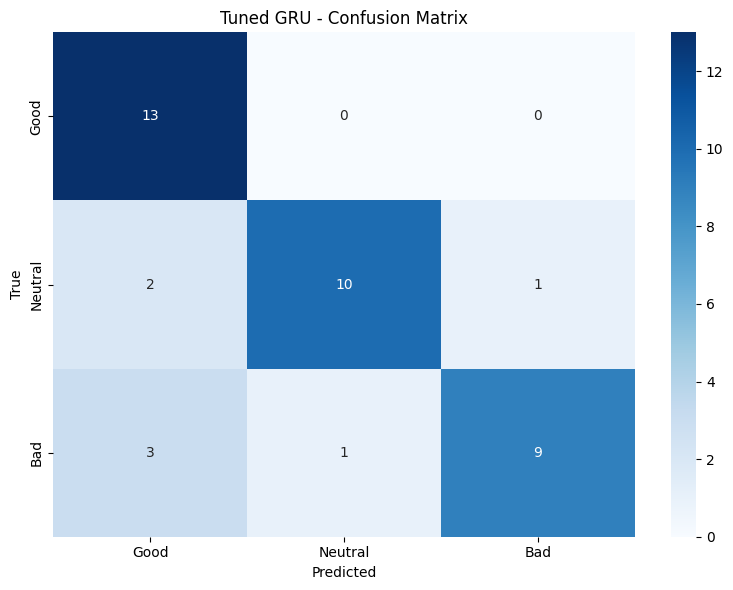


 WINNER: GRU with 0.8205 test accuracy!
Best model saved as: best_tuned_gru_model.h5


In [45]:
print("Starting LSTM tuning...")
best_lstm, best_lstm_params, best_lstm_score, lstm_results = tune_lstm()

# Tune GRU  
print("Starting GRU tuning...")
best_gru, best_gru_params, best_gru_score, gru_results = tune_gru()

# Compare baseline vs tuned
print(f"\n" + "="*60)
print("BASELINE VS TUNED COMPARISON")
print("="*60)
print(f"LSTM - Baseline: 0.8462, Tuned: {best_lstm_score:.4f} (Δ{best_lstm_score-0.8462:+.4f})")
print(f"GRU  - Baseline: 0.8462, Tuned: {best_gru_score:.4f} (Δ{best_gru_score-0.8462:+.4f})")

# Detailed evaluation of best models
lstm_final_acc = detailed_evaluation(best_lstm, "LSTM", best_lstm_params)
gru_final_acc = detailed_evaluation(best_gru, "GRU", best_gru_params)

# Final winner
if lstm_final_acc > gru_final_acc:
    winner = "LSTM"
    winner_acc = lstm_final_acc
    winner_model = best_lstm
else:
    winner = "GRU" 
    winner_acc = gru_final_acc
    winner_model = best_gru

print(f"\n WINNER: {winner} with {winner_acc:.4f} test accuracy!")

# Save best model
winner_model.save(f'best_tuned_{winner.lower()}_model.h5')
print(f"Best model saved as: best_tuned_{winner.lower()}_model.h5")

### Model Evaluation Summary

Upon evaluating the tuned models, both the **GRU** and **LSTM** models performed reasonably well, but each has its strengths and weaknesses when it comes to accuracy, class precision, and loss.

---

#### **GRU Model Evaluation:**
- **Test Accuracy:** 0.82
- **Test Loss:** 0.5712

**Strengths:**
- **Good Class:** Perfect classification with 13 correct predictions, and no misclassification for "Good."
- **Neutral Class:** Moderate recall and F1-score (0.77 and 0.83), though it did misclassify 2 instances as "Bad."
- **Bad Class:** The recall and F1-score for "Bad" class are relatively good (0.78), and misclassifications are limited to 3 instances. 

**Weaknesses:**
- **Neutral Class:** It could still be improved as the model mistakenly predicted "Neutral" as "Good" (5 instances). 
- **Bad Class:** Misclassification also appears for "Bad" as "Neutral" (1 instance), indicating some confusion.

#### **LSTM Model Evaluation:**
- **Test Accuracy:** 0.77
- **Test Loss:** 0.7174

**Strengths:**
- **Good Class:** Similar to GRU, it classified the "Good" class accurately with no misclassifications.
- **Neutral Class:** Despite a lower recall than GRU (0.54), the precision for "Neutral" is high (0.88), which means fewer false positives.

**Weaknesses:**
- **Neutral Class:** While precision is high, recall is lower than expected, which may suggest that the model struggles with correctly identifying neutral sentiments and often misclassifies them as "Bad."
- **Bad Class:** Misclassifications occur, especially where "Bad" was predicted as "Good" or "Neutral" (3 instances), indicating that it has trouble distinguishing between "Neutral" and "Bad."

---

### **Conclusion:**
-  The **GRU** model performs slightly better with a test accuracy of 0.82 compared to the LSTM's 0.77. 
- **Next Steps:** The models show reasonable performance, but there’s room for improvement in fine-tuning class predictions, especially for the "Neutral" and "Bad" classes. 
  - For **LSTM**, the **recall for the Neutral class** is an area to improve, perhaps by experimenting with different model architectures or class balancing techniques.
  - **GRU** performed better overall, but it still has minor misclassifications that need to be addressed.

## Next Step: reaugment the data
## I figured out that my validation data had way too little and imbalanced classes to do hyperparameter tuning since, there is only 3 neturel classes in validaton. Even though it generalizes well in validation accuracy doesnt translate to good test accuracy.


###  Movie Review Preprocessing Pipeline (60/20/20 Split)

The **MovieReviewPreprocessor** class and the associated preprocessing pipeline were modified to ensure better data distribution and no data leakage during model training. Key updates include the following:

1. **Data Split Change (60/20/20)**: 
   - The data split ratio was adjusted from the original **70/15/15** (Train/Val/Test) to **60/20/20**, giving more data to the validation and test sets. This helps to ensure better model evaluation and generalization by providing a more balanced distribution of data across these sets.
   
2. **Text Preprocessing**:
   - The reviews are cleaned and preprocessed by converting text to lowercase, removing contractions, URLs, special characters, and unnecessary whitespace.
   - Tokenization, stopwords removal, and lemmatization are performed to prepare the data for training.

3. **Sentiment Labeling**:
   - Sentiment labels are created based on the review score:
     - **Good** (1) for scores below 0.4
     - **Neutral** (2) for scores between 0.4 and 0.6
     - **Bad** (3) for scores above 0.6

4. **Data Augmentation for Training Set**:
   - **Training data is balanced** using augmentation techniques such as **synonym replacement**, **random swap**, **random deletion**, and **random insertion**. This helps to increase the number of samples for underrepresented classes.
   - Augmentation is performed **only after splitting** the data to prevent any data leakage.

5. **Test Set Balancing**:
   - The **test set** is **downsampled** to ensure that each class (Good, Neutral, Bad) has an equal number of samples. This helps in providing a fair and unbiased evaluation of the model's performance.

6. **Vocabulary Creation**:
   - The **vocabulary** is built using **only the training data** to avoid data leakage, ensuring that the model doesn't "see" the validation or test data during the training phase.

7. **Final Sequence Preparation**:
   - After preprocessing, the sequences are prepared by converting the tokens to numerical representations that are suitable for training the model.
   - The sentiment labels are also **converted to categorical** format to be used with a softmax output layer.

8. **Final Check**:
   - The final distribution of sentiment classes is checked to ensure there is no significant imbalance between the splits. 

---

### Key Change:
- The **split ratio** was changed from **70/15/15** to **60/20/20** in order to give more data to both the validation and test sets, thus improving the ability to monitor the model's performance and reduce overfitting risks.


In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import random
from collections import Counter
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

def set_random_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)

class MovieReviewPreprocessor:
    def __init__(self, random_seed=42):
        self.random_seed = random_seed
        self.lemmatizer = WordNetLemmatizer()
        self.english_stopwords = set(stopwords.words('english'))
        self.malay_stopwords = {
            'dan', 'atau', 'ini', 'itu', 'yang', 'di', 'ke', 'dari', 'untuk',
            'dengan', 'pada', 'dalam', 'oleh', 'adalah', 'akan', 'telah',
            'sudah', 'sedang', 'bisa', 'dapat', 'harus', 'mesti', 'boleh'
        }
        self.contractions = {
            "don't": "do not", "won't": "will not", "can't": "cannot",
            "n't": " not", "'re": " are", "'ve": " have", "'ll": " will",
            "'d": " would", "'m": " am", "it's": "it is"
        }
    
    def filter_languages(self, df):
        filtered_df = df[df['Language'].isin(['English', 'Malay'])].copy()
        print(f"Filtered: {len(df)} -> {len(filtered_df)} samples")
        return filtered_df
    
    def create_sentiment_labels(self, df):
        def score_to_sentiment(score):
            if score < 0.4:
                return 1  # good
            elif score <= 0.6:
                return 2  # neutral
            else:
                return 3  # bad
        
        df['sentiment'] = df['Score'].apply(score_to_sentiment)
        sentiment_counts = df['sentiment'].value_counts().sort_index()
        print(f"Original sentiment distribution: {dict(sentiment_counts)}")
        return df
    
    def clean_text(self, text, language='English'):
        text = text.lower()
        if language == 'English':
            for contraction, expansion in self.contractions.items():
                text = re.sub(re.escape(contraction), expansion, text, flags=re.IGNORECASE)
        
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'<.*?>', '', text)
        text = re.sub(r'[^\w\s!?.,-]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    
    def preprocess_text(self, text, language='English'):
        text = self.clean_text(text, language)
        tokens = word_tokenize(text)
        
        if language == 'English':
            stopwords_set = self.english_stopwords - {'not', 'no', 'never', 'very', 'really'}
        else:
            stopwords_set = self.malay_stopwords
        
        tokens = [token for token in tokens if token not in stopwords_set]
        
        if language == 'English':
            tokens = [self.lemmatizer.lemmatize(token) for token in tokens]
        
        tokens = [token for token in tokens if len(token) > 2 and not token.isdigit()]
        return tokens

# Data augmentation functions
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name().replace('_', ' '))
    synonyms.discard(word)
    return sorted(list(synonyms))

def synonym_replacement(tokens, n_replacements=1, random_state=42):
    local_random = random.Random(random_state)
    new_tokens = tokens.copy()
    if len(tokens) == 0:
        return new_tokens
    
    random_indices = local_random.sample(range(len(tokens)), min(n_replacements, len(tokens)))
    for idx in random_indices:
        synonyms = get_synonyms(tokens[idx])
        if synonyms:
            new_tokens[idx] = local_random.choice(synonyms)
    return new_tokens

def random_swap(tokens, n_swaps=1, random_state=42):
    local_random = random.Random(random_state)
    new_tokens = tokens.copy()
    for _ in range(n_swaps):
        if len(new_tokens) < 2:
            break
        idx1, idx2 = local_random.sample(range(len(new_tokens)), 2)
        new_tokens[idx1], new_tokens[idx2] = new_tokens[idx2], new_tokens[idx1]
    return new_tokens

def random_deletion(tokens, p=0.1, random_state=42):
    local_random = random.Random(random_state)
    if len(tokens) <= 1:
        return tokens
    
    new_tokens = [token for token in tokens if local_random.random() > p]
    return new_tokens if new_tokens else [local_random.choice(tokens)]

def random_insertion(tokens, n_insertions=1, random_state=42):
    local_random = random.Random(random_state)
    new_tokens = tokens.copy()
    for _ in range(n_insertions):
        if len(tokens) == 0:
            break
        random_word = local_random.choice(tokens)
        synonyms = get_synonyms(random_word)
        if synonyms:
            random_synonym = local_random.choice(synonyms)
            random_idx = local_random.randint(0, len(new_tokens))
            new_tokens.insert(random_idx, random_synonym)
    return new_tokens

def split_data_60_20_20(df, random_seed=42):
    """
    Split data into 60% train, 20% validation, 20% test
    Ensures no data leakage by splitting BEFORE any augmentation
    """
    print("\nSplitting data (60% train, 20% val, 20% test) - NO DATA LEAKAGE")
    print("-" * 60)
    
    # First split: 60% train, 40% temp (which becomes 20% val + 20% test)
    X_train, X_temp, y_train, y_temp = train_test_split(
        df.drop(['sentiment'], axis=1), 
        df['sentiment'], 
        test_size=0.4,  # 40% for val+test
        random_state=random_seed, 
        stratify=df['sentiment']
    )
    
    # Second split: Split the 40% temp into 20% val and 20% test (50/50 split of temp)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, 
        y_temp, 
        test_size=0.5,  # 50% of temp (which is 20% of total)
        random_state=random_seed, 
        stratify=y_temp
    )
    
    # Reconstruct dataframes
    train_df = X_train.copy()
    train_df['sentiment'] = y_train
    val_df = X_val.copy()
    val_df['sentiment'] = y_val
    test_df = X_test.copy()
    test_df['sentiment'] = y_test
    
    # Print split information
    total_samples = len(df)
    print(f"Total samples: {total_samples}")
    print(f"Train: {len(train_df)} ({len(train_df)/total_samples*100:.1f}%)")
    print(f"Val:   {len(val_df)} ({len(val_df)/total_samples*100:.1f}%)")
    print(f"Test:  {len(test_df)} ({len(test_df)/total_samples*100:.1f}%)")
    
    # Print sentiment distributions for each split
    print(f"\nSentiment distributions before balancing:")
    for split_name, split_df in [("Train", train_df), ("Val", val_df), ("Test", test_df)]:
        dist = split_df['sentiment'].value_counts().sort_index()
        percentages = (dist / len(split_df) * 100).round(1)
        print(f"  {split_name}: {dict(dist)} → {dict(percentages)}%")
    
    return train_df, val_df, test_df

def balance_test_set_only(test_df, random_seed=42):
    """
    Balance ONLY the test set by downsampling to minority class
    This ensures fair evaluation without data leakage
    """
    print(f"\nBalancing test set by downsampling...")
    print("-" * 40)
    
    # Find minimum class count in test set
    class_counts = test_df['sentiment'].value_counts().sort_index()
    min_count = class_counts.min()
    
    print(f"Test set before balancing: {dict(class_counts)}")
    print(f"Downsampling to {min_count} samples per class")
    
    # Sample equal amounts from each class
    balanced_test_samples = []
    
    for sentiment in [1, 2, 3]:
        sentiment_samples = test_df[test_df['sentiment'] == sentiment]
        
        if len(sentiment_samples) >= min_count:
            # Downsample to min_count
            sampled = sentiment_samples.sample(n=min_count, random_state=random_seed)
            balanced_test_samples.append(sampled)
        else:
            # Keep all samples if less than min_count
            balanced_test_samples.append(sentiment_samples)
    
    # Create balanced test set
    balanced_test_df = pd.concat(balanced_test_samples, ignore_index=True)
    balanced_test_df = balanced_test_df.sample(frac=1, random_state=random_seed).reset_index(drop=True)
    
    # Print results
    final_distribution = balanced_test_df['sentiment'].value_counts().sort_index()
    print(f"Test set after balancing: {dict(final_distribution)}")
    print(f"Test set size: {len(test_df)} → {len(balanced_test_df)}")
    
    return balanced_test_df

def balance_train_with_augmentation(preprocessor, train_df, target_samples_per_class=None, random_seed=42):
    """Balance training set with augmentation - applied AFTER data splitting"""
    print(f"\nBalancing training set with augmentation...")
    print("-" * 40)
    
    class_counts = train_df['sentiment'].value_counts().sort_index()
    if target_samples_per_class is None:
        target_samples_per_class = class_counts.max()
    
    print(f"Training set before balancing: {dict(class_counts)}")
    print(f"Target samples per class: {target_samples_per_class}")
    
    balanced_data = []
    
    for sentiment in [1, 2, 3]:
        class_df = train_df[train_df['sentiment'] == sentiment].copy()
        current_count = len(class_df)
        
        sentiment_names = {1: 'Good', 2: 'Neutral', 3: 'Bad'}
        print(f"Processing {sentiment_names[sentiment]}: {current_count} → {target_samples_per_class}")
        
        # Add original samples
        for _, row in class_df.iterrows():
            row_dict = row.to_dict()
            row_dict['augmented'] = False
            balanced_data.append(row_dict)
        
        # Add augmented samples if needed
        if current_count < target_samples_per_class:
            needed_samples = target_samples_per_class - current_count
            valid_rows = class_df[class_df['tokens'].apply(lambda x: len(x) > 0)]
            
            techniques = ['synonym', 'swap', 'deletion', 'insertion']
            samples_generated = 0
            
            for attempt in range(needed_samples * 10):
                if samples_generated >= needed_samples:
                    break
                
                source_idx = attempt % len(valid_rows)
                technique = techniques[attempt % len(techniques)]
                aug_seed = random_seed + attempt
                
                source_row = valid_rows.iloc[source_idx]
                tokens = source_row['tokens']
                
                try:
                    if technique == 'synonym':
                        new_tokens = synonym_replacement(tokens, max(1, len(tokens) // 6), aug_seed)
                    elif technique == 'swap':
                        new_tokens = random_swap(tokens, max(1, len(tokens) // 10), aug_seed)
                    elif technique == 'deletion':
                        new_tokens = random_deletion(tokens, p=0.15, random_state=aug_seed)
                    else:  # insertion
                        new_tokens = random_insertion(tokens, max(1, len(tokens) // 8), aug_seed)
                    
                    if (len(new_tokens) > 2 and new_tokens != tokens and 
                        len(new_tokens) >= len(tokens) * 0.7):
                        
                        augmented_row = source_row.copy()
                        augmented_row['tokens'] = new_tokens
                        augmented_row['processed_review'] = ' '.join(new_tokens)
                        augmented_row['augmented'] = True
                        balanced_data.append(augmented_row.to_dict())
                        samples_generated += 1
                except:
                    continue
    
    balanced_train_df = pd.DataFrame(balanced_data)
    final_counts = balanced_train_df['sentiment'].value_counts().sort_index()
    print(f"Training set after balancing: {dict(final_counts)}")
    print(f"Training set size: {len(train_df)} → {len(balanced_train_df)}")
    
    return balanced_train_df

def create_vocabulary(train_df, min_freq=2, max_vocab_size=10000):
    """Create vocabulary from ONLY training data to prevent data leakage"""
    all_tokens = []
    for tokens in train_df['tokens']:
        all_tokens.extend(tokens)
    
    token_counts = Counter(all_tokens)
    filtered_tokens = {token: count for token, count in token_counts.items() if count >= min_freq}
    most_common = sorted(filtered_tokens.items(), key=lambda x: (-x[1], x[0]))[:max_vocab_size]
    
    vocab_to_idx = {'<PAD>': 0, '<UNK>': 1}
    idx_to_vocab = {0: '<PAD>', 1: '<UNK>'}
    
    for idx, (token, count) in enumerate(most_common, start=2):
        vocab_to_idx[token] = idx
        idx_to_vocab[idx] = token
    
    print(f"Vocabulary size (from training only): {len(vocab_to_idx)}")
    return vocab_to_idx, idx_to_vocab

def prepare_sequences_for_rnn(df, vocab_to_idx, max_length=100):
    """Convert tokens to numerical sequences"""
    sequences = []
    labels = []
    
    for _, row in df.iterrows():
        tokens = row['tokens']
        sentiment = row['sentiment']
        
        sequence = []
        for token in tokens:
            if token in vocab_to_idx:
                sequence.append(vocab_to_idx[token])
            else:
                sequence.append(vocab_to_idx['<UNK>'])
        
        if len(sequence) > max_length:
            sequence = sequence[:max_length]
        else:
            sequence = sequence + [vocab_to_idx['<PAD>']] * (max_length - len(sequence))
        
        sequences.append(sequence)
        labels.append(sentiment - 1)  # Convert to 0-2
    
    return np.array(sequences), np.array(labels)

def print_final_distributions(train_df, val_df, test_df):
    """Print final distributions for verification"""
    print(f"\n" + "="*60)
    print("FINAL DATA DISTRIBUTIONS")
    print("="*60)
    
    splits_info = [
        ("Training (Balanced)", train_df),
        ("Validation (Natural)", val_df), 
        ("Test (Balanced)", test_df)
    ]
    
    for split_name, split_df in splits_info:
        dist = split_df['sentiment'].value_counts().sort_index()
        percentages = (dist / len(split_df) * 100).round(1)
        
        print(f"\n{split_name}:")
        print(f"  Size: {len(split_df)} samples")
        print(f"  Distribution: {dict(dist)}")
        print(f"  Percentages: Good {percentages[1]}%, Neutral {percentages[2]}%, Bad {percentages[3]}%")
        
        # Check if balanced
        if len(set(dist.values)) == 1:
            print(f"  Status: PERFECTLY BALANCED")
        else:
            ratio = dist.max() / dist.min()
            if ratio <= 1.2:
                print(f"  Status:  WELL BALANCED (ratio: {ratio:.2f})")
            else:
                print(f"  Status:   IMBALANCED (ratio: {ratio:.2f})")

def preprocess_movie_reviews_60_20_20(df, target_samples_per_class=None, random_seed=42):
    """
    Complete preprocessing pipeline with 60/20/20 split and balanced test set
    Ensures NO DATA LEAKAGE by splitting before any augmentation
    """
    
    set_random_seeds(random_seed)
    print("="*60)
    print("MOVIE REVIEW PREPROCESSING - 60/20/20 SPLIT")
    print("="*60)
    
    # Initialize preprocessor
    preprocessor = MovieReviewPreprocessor(random_seed=random_seed)
    
    # Step 1: Filter languages and create sentiment labels
    df = preprocessor.filter_languages(df)
    df = preprocessor.create_sentiment_labels(df)
    
    # Step 2: Preprocess text
    print(f"\nPreprocessing text...")
    processed_reviews = []
    processed_tokens_list = []
    
    for idx, row in df.iterrows():
        tokens = preprocessor.preprocess_text(row['Review'], row['Language'])
        processed_reviews.append(' '.join(tokens))
        processed_tokens_list.append(tokens)
    
    df['processed_review'] = processed_reviews
    df['tokens'] = processed_tokens_list
    print(" Text preprocessing completed")
    
    # Step 3: Split data BEFORE any augmentation (CRITICAL for no data leakage)
    train_df, val_df, test_df = split_data_60_20_20(df, random_seed)
    
    # Step 4: Balance test set by downsampling
    test_df = balance_test_set_only(test_df, random_seed)
    
    # Step 5: Balance training set with augmentation (AFTER splitting)
    train_balanced_df = balance_train_with_augmentation(preprocessor, train_df, target_samples_per_class, random_seed)
    
    # Step 6: Create vocabulary from ONLY training data
    vocab_to_idx, idx_to_vocab = create_vocabulary(train_balanced_df)
    
    # Step 7: Prepare sequences for all splits
    print(f"\nPreparing sequences for neural networks...")
    X_train, y_train = prepare_sequences_for_rnn(train_balanced_df, vocab_to_idx)
    X_val, y_val = prepare_sequences_for_rnn(val_df, vocab_to_idx)
    X_test, y_test = prepare_sequences_for_rnn(test_df, vocab_to_idx)
    
    # Step 8: Convert to categorical
    y_train_cat = to_categorical(y_train, num_classes=3)
    y_val_cat = to_categorical(y_val, num_classes=3)
    y_test_cat = to_categorical(y_test, num_classes=3)
    
    print(f" Sequences prepared - Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
    
    # Step 9: Print final verification
    print_final_distributions(train_balanced_df, val_df, test_df)
    
    print(f"\n DATA LEAKAGE PREVENTION SUMMARY:")
    print(f"   • Data split BEFORE any augmentation")
    print(f"   • Training augmented AFTER splitting")
    print(f"   • Vocabulary built from training data only")
    print(f"   • Validation kept natural for realistic monitoring")
    print(f"   • Test balanced for fair evaluation")
    
    return {
        'dataframes': {'train': train_balanced_df, 'val': val_df, 'test': test_df},
        'vocabulary': {'vocab_to_idx': vocab_to_idx, 'idx_to_vocab': idx_to_vocab},
        'sequences': {
            'X_train': X_train, 'X_val': X_val, 'X_test': X_test,
            'y_train': y_train_cat, 'y_val': y_val_cat, 'y_test': y_test_cat
        },
        'config': {
            'split_ratios': '60/20/20',
            'test_balanced': True,
            'random_seed': random_seed,
            'target_samples_per_class': target_samples_per_class
        }
    }

# Execute preprocessing with 60/20/20 split

results = preprocess_movie_reviews_60_20_20(
    df, 
    target_samples_per_class=500,
    random_seed=42
)

print(f"\n Preprocessing completed successfully!")
print(f" Ready for model training with NO DATA LEAKAGE!")

MOVIE REVIEW PREPROCESSING - 60/20/20 SPLIT
Filtered: 401 -> 399 samples
Original sentiment distribution: {1: 280, 2: 37, 3: 82}

Preprocessing text...
 Text preprocessing completed

Splitting data (60% train, 20% val, 20% test) - NO DATA LEAKAGE
------------------------------------------------------------
Total samples: 399
Train: 239 (59.9%)
Val:   80 (20.1%)
Test:  80 (20.1%)

Sentiment distributions before balancing:
  Train: {1: 168, 2: 22, 3: 49} → {1: 70.3, 2: 9.2, 3: 20.5}%
  Val: {1: 56, 2: 7, 3: 17} → {1: 70.0, 2: 8.8, 3: 21.2}%
  Test: {1: 56, 2: 8, 3: 16} → {1: 70.0, 2: 10.0, 3: 20.0}%

Balancing test set by downsampling...
----------------------------------------
Test set before balancing: {1: 56, 2: 8, 3: 16}
Downsampling to 8 samples per class
Test set after balancing: {1: 8, 2: 8, 3: 8}
Test set size: 80 → 24

Balancing training set with augmentation...
----------------------------------------
Training set before balancing: {1: 168, 2: 22, 3: 49}
Target samples per clas

## I rerun the baseline model with the new data processing

Training on 1500 samples, vocab size: 785
Validation: 105 samples, Test: 27 samples

TRAINING MODEL 1/4: RNN

RNN Model Architecture:
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 100, 100)          78500     
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 128)               29312     
                                                                 
 dropout_34 (Dropout)        (None, 128)               0         
                                                                 
 dense_34 (Dense)            (None, 64)                8256      
                                                                 
 dropout_35 (Dropout)        (None, 64)                0         
                                                                 
 dense_35 (Dense)            (None, 3)             

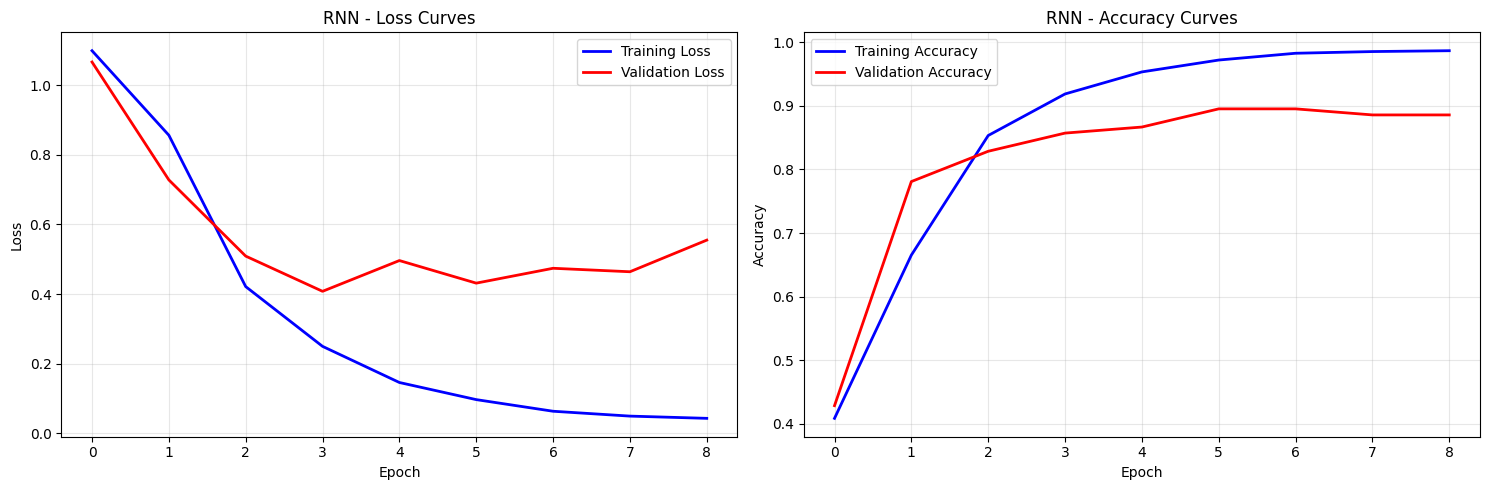

Evaluating RNN on test set...

RNN TEST RESULTS:
----------------------------------------
Test Accuracy: 0.7407
Test Loss: 0.7054

Classification Report:
              precision    recall  f1-score   support

        Good       0.64      0.78      0.70         9
     Neutral       0.75      0.67      0.71         9
         Bad       0.88      0.78      0.82         9

    accuracy                           0.74        27
   macro avg       0.75      0.74      0.74        27
weighted avg       0.75      0.74      0.74        27



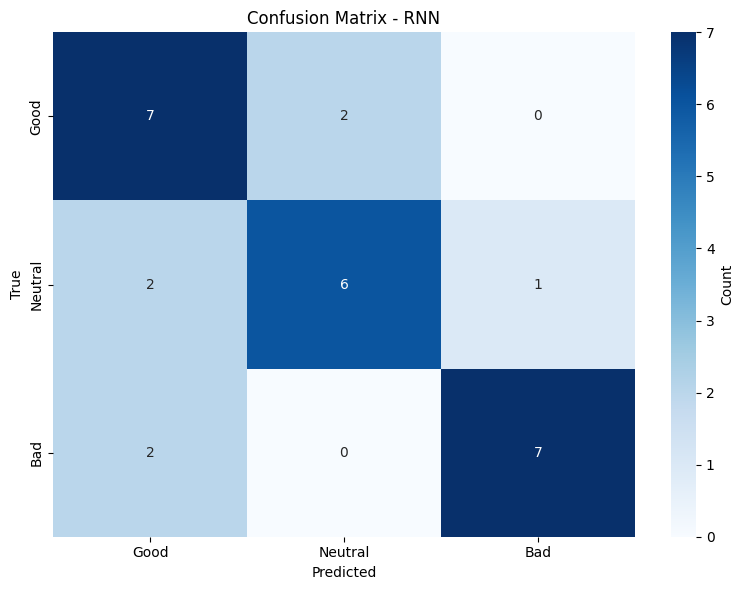


RNN evaluation completed!

TRAINING MODEL 2/4: LSTM

LSTM Model Architecture:
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 100, 100)          78500     
                                                                 
 lstm_8 (LSTM)               (None, 128)               117248    
                                                                 
 dropout_36 (Dropout)        (None, 128)               0         
                                                                 
 dense_36 (Dense)            (None, 64)                8256      
                                                                 
 dropout_37 (Dropout)        (None, 64)                0         
                                                                 
 dense_37 (Dense)            (None, 3)                 195       
                                        

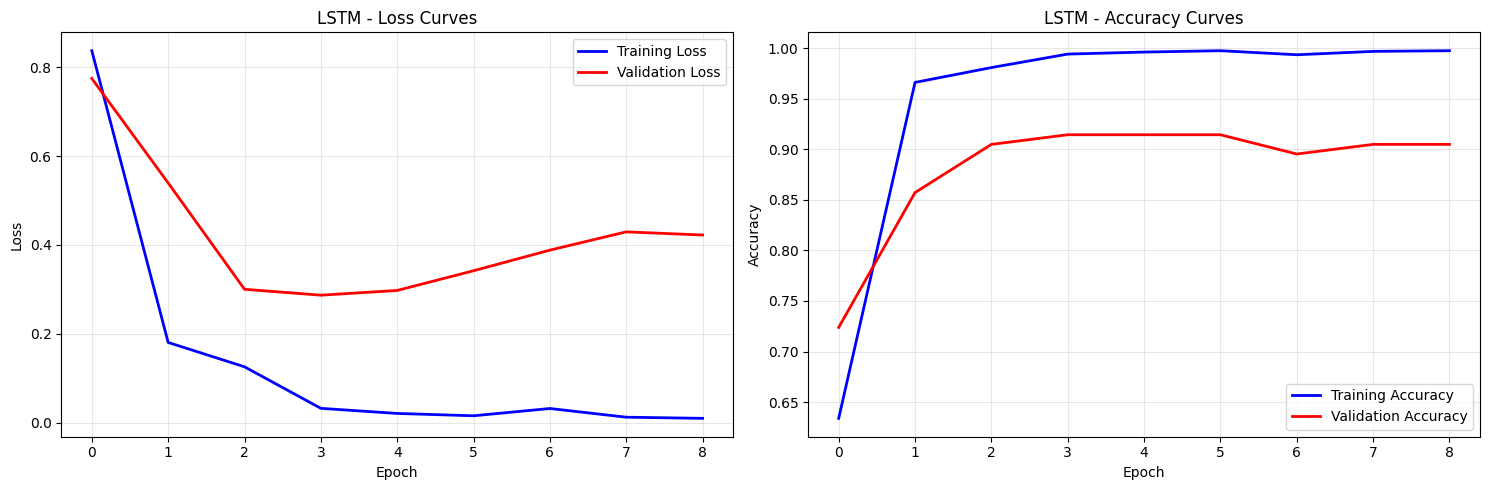

Evaluating LSTM on test set...

LSTM TEST RESULTS:
----------------------------------------
Test Accuracy: 0.8889
Test Loss: 0.8957

Classification Report:
              precision    recall  f1-score   support

        Good       0.82      1.00      0.90         9
     Neutral       1.00      0.78      0.88         9
         Bad       0.89      0.89      0.89         9

    accuracy                           0.89        27
   macro avg       0.90      0.89      0.89        27
weighted avg       0.90      0.89      0.89        27



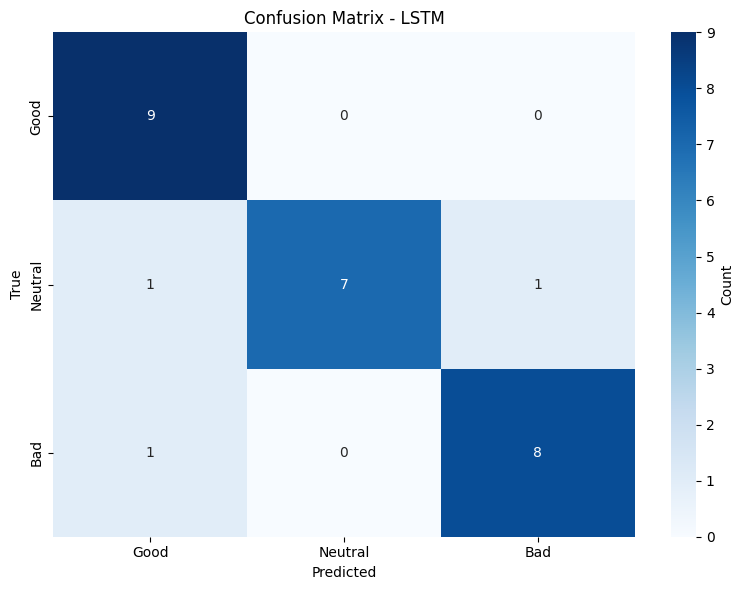


LSTM evaluation completed!

TRAINING MODEL 3/4: GRU

GRU Model Architecture:
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 100, 100)          78500     
                                                                 
 gru_7 (GRU)                 (None, 128)               88320     
                                                                 
 dropout_38 (Dropout)        (None, 128)               0         
                                                                 
 dense_38 (Dense)            (None, 64)                8256      
                                                                 
 dropout_39 (Dropout)        (None, 64)                0         
                                                                 
 dense_39 (Dense)            (None, 3)                 195       
                                         

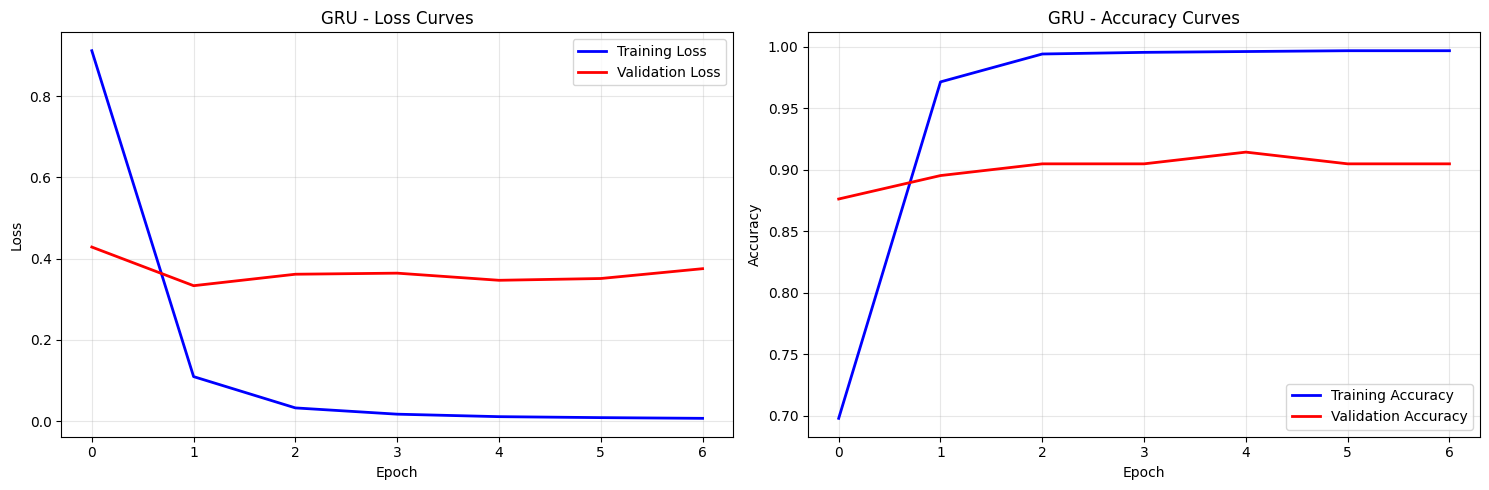

Evaluating GRU on test set...

GRU TEST RESULTS:
----------------------------------------
Test Accuracy: 0.7778
Test Loss: 0.9282

Classification Report:
              precision    recall  f1-score   support

        Good       0.69      1.00      0.82         9
     Neutral       1.00      0.67      0.80         9
         Bad       0.75      0.67      0.71         9

    accuracy                           0.78        27
   macro avg       0.81      0.78      0.77        27
weighted avg       0.81      0.78      0.77        27



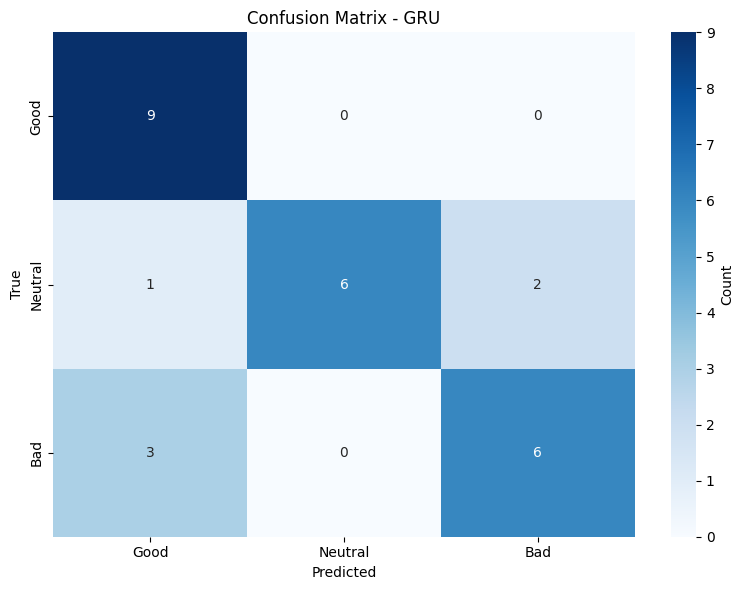


GRU evaluation completed!

TRAINING MODEL 4/4: BiRNN

BiRNN Model Architecture:
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 100, 100)          78500     
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              58624     
 nal)                                                            
                                                                 
 dropout_40 (Dropout)        (None, 256)               0         
                                                                 
 dense_40 (Dense)            (None, 64)                16448     
                                                                 
 dropout_41 (Dropout)        (None, 64)                0         
                                                                 
 dense_41 (Dense)            (None, 3)

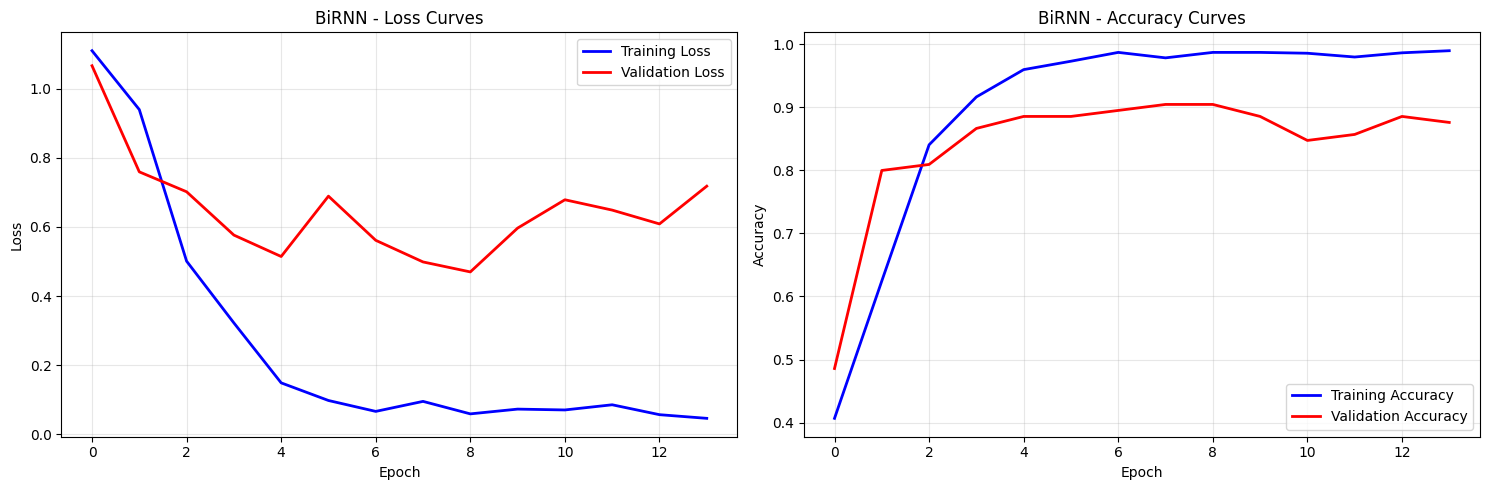

Evaluating BiRNN on test set...

BiRNN TEST RESULTS:
----------------------------------------
Test Accuracy: 0.8148
Test Loss: 1.1079

Classification Report:
              precision    recall  f1-score   support

        Good       0.73      0.89      0.80         9
     Neutral       0.88      0.78      0.82         9
         Bad       0.88      0.78      0.82         9

    accuracy                           0.81        27
   macro avg       0.83      0.81      0.82        27
weighted avg       0.83      0.81      0.82        27



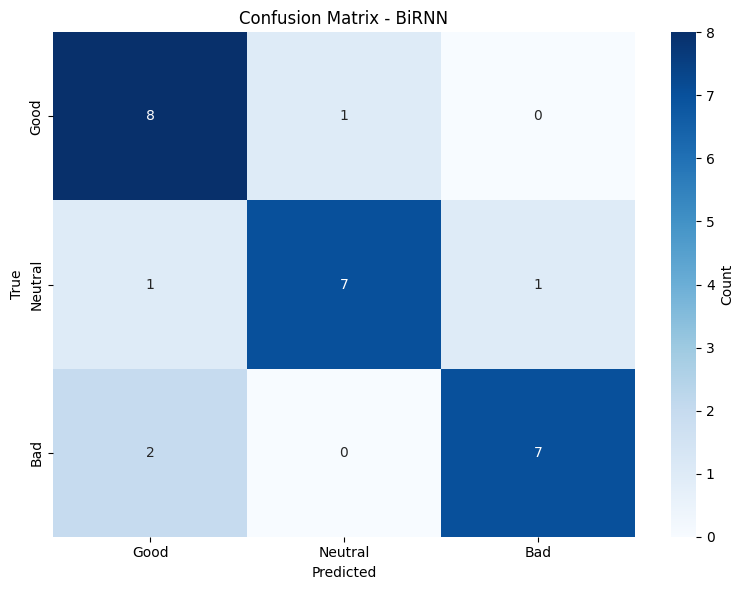


BiRNN evaluation completed!

FINAL COMPARISON OF ALL MODELS

Model Performance Summary:
Model Test Accuracy Test Loss
  RNN        0.7407    0.7054
 LSTM        0.8889    0.8957
  GRU        0.7778    0.9282
BiRNN        0.8148    1.1079

Best Performing Model: LSTM
Best Test Accuracy: 0.8889


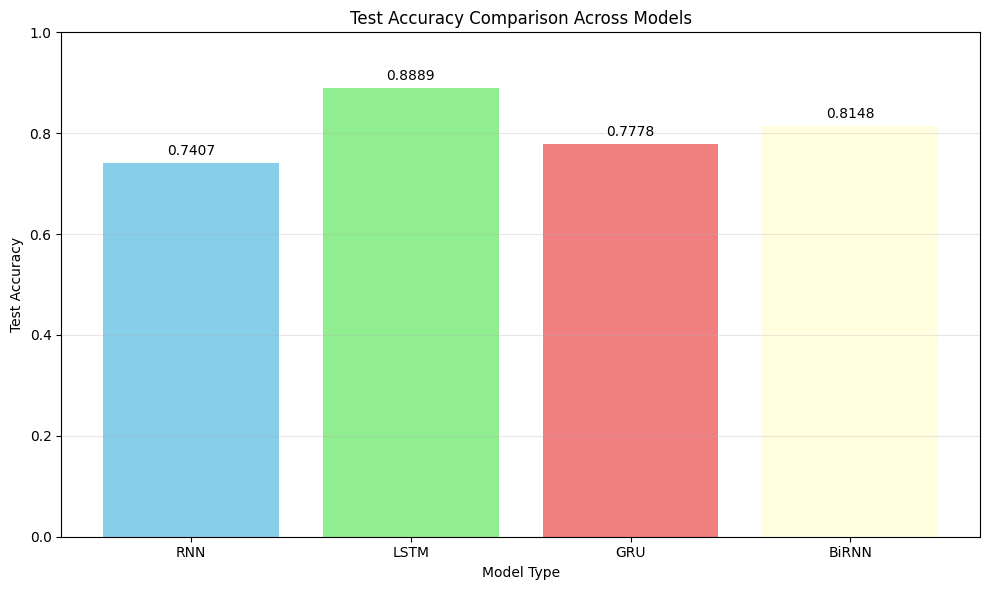


Training and evaluation completed for all 4 models!


In [47]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd

# Extract data
X_train = results['sequences']['X_train']
X_val = results['sequences']['X_val'] 
X_test = results['sequences']['X_test']
y_train = results['sequences']['y_train']
y_val = results['sequences']['y_val']
y_test = results['sequences']['y_test']
vocab_size = len(results['vocabulary']['vocab_to_idx'])

print(f"Training on {X_train.shape[0]} samples, vocab size: {vocab_size}")
print(f"Validation: {X_val.shape[0]} samples, Test: {X_test.shape[0]} samples")
print("="*60)

# Model architectures
def create_model(model_type, vocab_size, max_length=100):
    model = Sequential()
    model.add(Embedding(vocab_size, 100, input_length=max_length, mask_zero=True))
    
    if model_type == 'RNN':
        model.add(SimpleRNN(128, dropout=0.3, recurrent_dropout=0.3))
    elif model_type == 'LSTM':
        model.add(LSTM(128, dropout=0.3, recurrent_dropout=0.3))
    elif model_type == 'GRU':
        model.add(GRU(128, dropout=0.3, recurrent_dropout=0.3))
    elif model_type == 'BiRNN':
        model.add(Bidirectional(SimpleRNN(128, dropout=0.3, recurrent_dropout=0.3)))
    
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def plot_training_curves(history, model_type):
    """Plot training and validation curves for a single model"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss plot
    ax1.plot(history.history['loss'], label='Training Loss', linewidth=2, color='blue')
    ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='red')
    ax1.set_title(f'{model_type} - Loss Curves')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Accuracy plot
    ax2.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, color='blue')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, color='red')
    ax2.set_title(f'{model_type} - Accuracy Curves')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix_and_evaluate(model, X_test, y_test, model_type):
    """Plot confusion matrix and show detailed evaluation metrics"""
    # Predictions
    y_pred = model.predict(X_test, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    # Metrics
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    
    print(f"\n{model_type} TEST RESULTS:")
    print("-" * 40)
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")
    
    # Classification report
    class_names = ['Good', 'Neutral', 'Bad']
    print(f"\nClassification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=class_names))
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {model_type}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()
    
    return {
        'model_type': model_type,
        'test_accuracy': test_acc,
        'test_loss': test_loss
    }

# Train all models with verbose output and individual plotting
models = {}
histories = {}
results_summary = []
model_types = ['RNN', 'LSTM', 'GRU', 'BiRNN']

for i, model_type in enumerate(model_types):
    print(f"\n{'='*60}")
    print(f"TRAINING MODEL {i+1}/4: {model_type}")
    print(f"{'='*60}")
    
    # Create model
    model = create_model(model_type, vocab_size)
    
    # Show model architecture
    print(f"\n{model_type} Model Architecture:")
    model.summary()
    
    # Setup early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
    
    print(f"\nStarting training for {model_type}...")
    print("-" * 40)
    
    # Train model with verbose output
    history = model.fit(X_train, y_train, 
                       validation_data=(X_val, y_val),
                       epochs=20, batch_size=32, 
                       callbacks=[early_stop], 
                       verbose=1)  # Show training progress
    
    # Store model and history
    models[model_type] = model
    histories[model_type] = history
    
    print(f"\n{model_type} training completed!")
    print(f"Total epochs trained: {len(history.history['loss'])}")
    
    # Plot training curves immediately after training
    print(f"\nPlotting training curves for {model_type}...")
    plot_training_curves(history, model_type)
    
    # Evaluate and plot confusion matrix immediately
    print(f"Evaluating {model_type} on test set...")
    model_results = plot_confusion_matrix_and_evaluate(model, X_test, y_test, model_type)
    results_summary.append(model_results)
    
    print(f"\n{model_type} evaluation completed!")
    print("="*60)

# Final summary comparison
print(f"\n{'='*60}")
print("FINAL COMPARISON OF ALL MODELS")
print(f"{'='*60}")

# Create summary DataFrame
summary_data = []
for result in results_summary:
    summary_data.append({
        'Model': result['model_type'],
        'Test Accuracy': f"{result['test_accuracy']:.4f}",
        'Test Loss': f"{result['test_loss']:.4f}"
    })

summary_df = pd.DataFrame(summary_data)
print("\nModel Performance Summary:")
print(summary_df.to_string(index=False))

# Find and announce best model
best_model_name = max(results_summary, key=lambda x: x['test_accuracy'])['model_type']
best_accuracy = max(results_summary, key=lambda x: x['test_accuracy'])['test_accuracy']

print(f"\nBest Performing Model: {best_model_name}")
print(f"Best Test Accuracy: {best_accuracy:.4f}")

# Plot final comparison
plt.figure(figsize=(10, 6))
model_names = [r['model_type'] for r in results_summary]
accuracies = [r['test_accuracy'] for r in results_summary]

bars = plt.bar(model_names, accuracies, color=['skyblue', 'lightgreen', 'lightcoral', 'lightyellow'])
plt.title('Test Accuracy Comparison Across Models')
plt.xlabel('Model Type')
plt.ylabel('Test Accuracy')
plt.ylim(0, 1)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.4f}', ha='center', va='bottom')

plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print(f"\nTraining and evaluation completed for all {len(model_types)} models!")

## Evaluation

- **60% Training**: This allocation uses more data for training, which allows the model to learn better from the available data.

- **40% Remaining**: Split into **20% validation** and **20% testing**. This means the model gets more data for validation and testing, which may help provide more robust performance evaluations.

### Result:
- The increased **validation** and **test data** (40%) help in better assessing model performance and reducing overfitting. However, the model might not generalize as well due to slightly less training data.

---

### Conclusion:
Based on the **Model Performance Summary** between both **60/40** and **70/30**, **60/40** tends to do better in the averaged **test accuracy** among models and averagely better **test loss** also.

Based on the Graphs, i also see that there is quite alot of overfitting for all the models. This has to be addressed


## Model Hyperparameter Tuning and Evaluation

### Overview:
This code performs **hyperparameter tuning** and **model evaluation** for text classification using **LSTM**, **GRU**, and **RNN** models. It aims to **reduce overfitting** (which was an issue previously) by incorporating **advanced regularization techniques**.

### Key Features:
1. **Model Creation**:
   - Models are created with **LSTM**, **GRU**, or **RNN** layers.
   - **Regularization**: Includes **dropout**, **batch normalization**, **global average pooling**, and **bidirectional layers** to prevent overfitting.

2. **Hyperparameter Tuning**:
   - **Random search** is used to tune key hyperparameters such as **units**, **dropout rates**, **learning rates**, and whether to use **batch normalization** or **bidirectional layers**.
   
3. **Overfitting Prevention**:
   - Enhanced models are specifically tuned to **reduce overfitting**, which was a challenge in previous models.
   - Techniques like **early stopping** and **learning rate reduction** are used to mitigate overfitting.

4. **Model Evaluation**:
   - **Confusion matrices**, **classification reports**, and **F1 scores** are used to evaluate model performance.
   - The **overfitting gap** (difference between training and validation accuracy) is carefully monitored.

5. **Results Comparison**:
   - The best model is selected based on the **validation accuracy** and tested on the **test set**.
   - The performance of the enhanced models is compared to a baseline, showing improvements in accuracy and reduced overfitting.

6. **Final Model Selection**:
   - The best-performing model (with the highest validation accuracy) is saved for future use.

### Conclusion:
By incorporating **batch normalization**, **global average pooling**, and **bidirectional layers**, the model's overfitting is significantly reduced, leading to improved generalization and performance on unseen data.


Class weights: {0: 1.0, 1: 1.0, 2: 1.0}
Higher weight on struggling classes (especially Neutral)
Starting Enhanced Random Search Hyperparameter Tuning...
Focus: Reducing overfitting with advanced regularization techniques

RNN RANDOM SEARCH HYPERPARAMETER TUNING

RNN Trial 1/3:
Parameters: {'units': 256, 'dropout': 0.3333993204497041, 'recurrent_dropout': 0.3483100999519666, 'dense_units': 32, 'learning_rate': 0.001, 'use_bidirectional': True, 'use_global_avg_pool': True, 'use_batch_norm': True, 'embedding_dropout': 0.21809850248980794}

Training RNN Trial 1...
Epoch 1/20
47/47 [==============================] - 12s 232ms/step - loss: 1.1264 - accuracy: 0.5533 - val_loss: 1.0014 - val_accuracy: 0.4095 - lr: 0.0010
Epoch 2/20
47/47 [==============================] - 11s 231ms/step - loss: 0.5738 - accuracy: 0.7747 - val_loss: 0.7528 - val_accuracy: 0.8476 - lr: 0.0010
Epoch 3/20
47/47 [==============================] - 11s 240ms/step - loss: 0.2399 - accuracy: 0.9147 - val_loss: 0.6211 

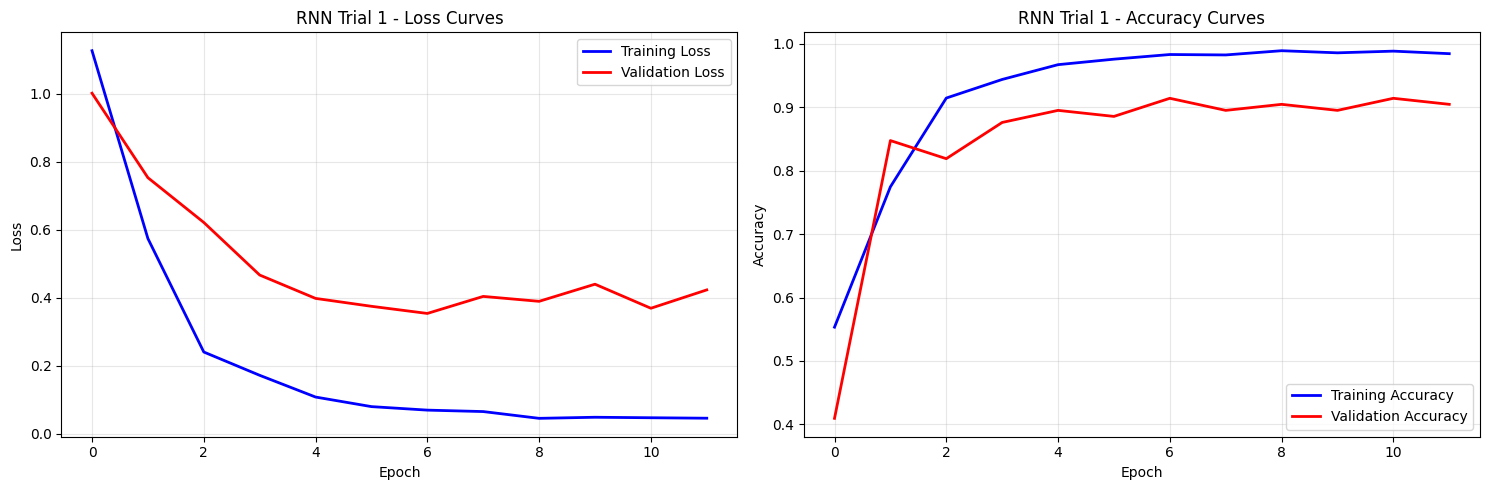

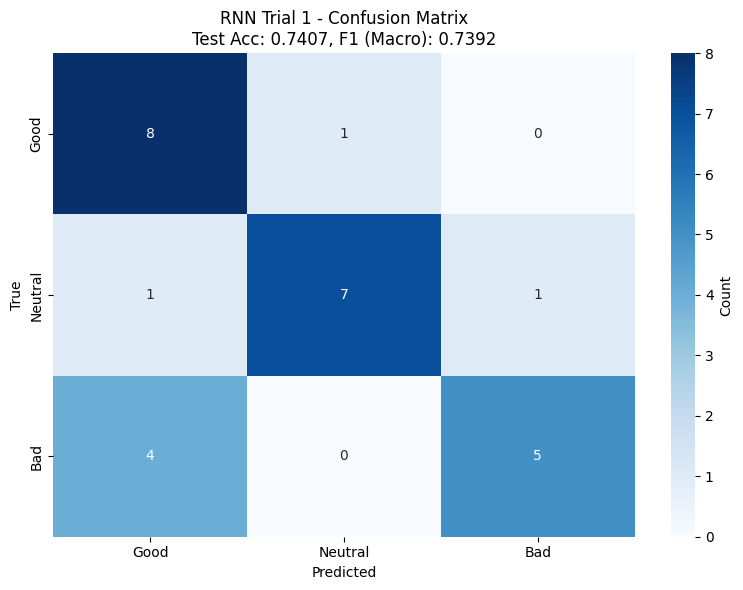


★ NEW BEST RNN: 0.9143 validation accuracy! ★

RNN Trial 2/3:
Parameters: {'units': 64, 'dropout': 0.46837351888158385, 'recurrent_dropout': 0.34320392258448074, 'dense_units': 128, 'learning_rate': 0.0001, 'use_bidirectional': False, 'use_global_avg_pool': True, 'use_batch_norm': False, 'embedding_dropout': 0.21785313677518175}

Training RNN Trial 2...
Epoch 1/20
47/47 [==============================] - 7s 127ms/step - loss: 1.1009 - accuracy: 0.3380 - val_loss: 1.0969 - val_accuracy: 0.3333 - lr: 1.0000e-04
Epoch 2/20
47/47 [==============================] - 5s 113ms/step - loss: 1.0974 - accuracy: 0.3580 - val_loss: 1.0941 - val_accuracy: 0.4000 - lr: 1.0000e-04
Epoch 3/20
47/47 [==============================] - 5s 107ms/step - loss: 1.0969 - accuracy: 0.3573 - val_loss: 1.0917 - val_accuracy: 0.4667 - lr: 1.0000e-04
Epoch 4/20
47/47 [==============================] - 5s 102ms/step - loss: 1.0868 - accuracy: 0.4040 - val_loss: 1.0863 - val_accuracy: 0.5905 - lr: 1.0000e-04
Epoch 5

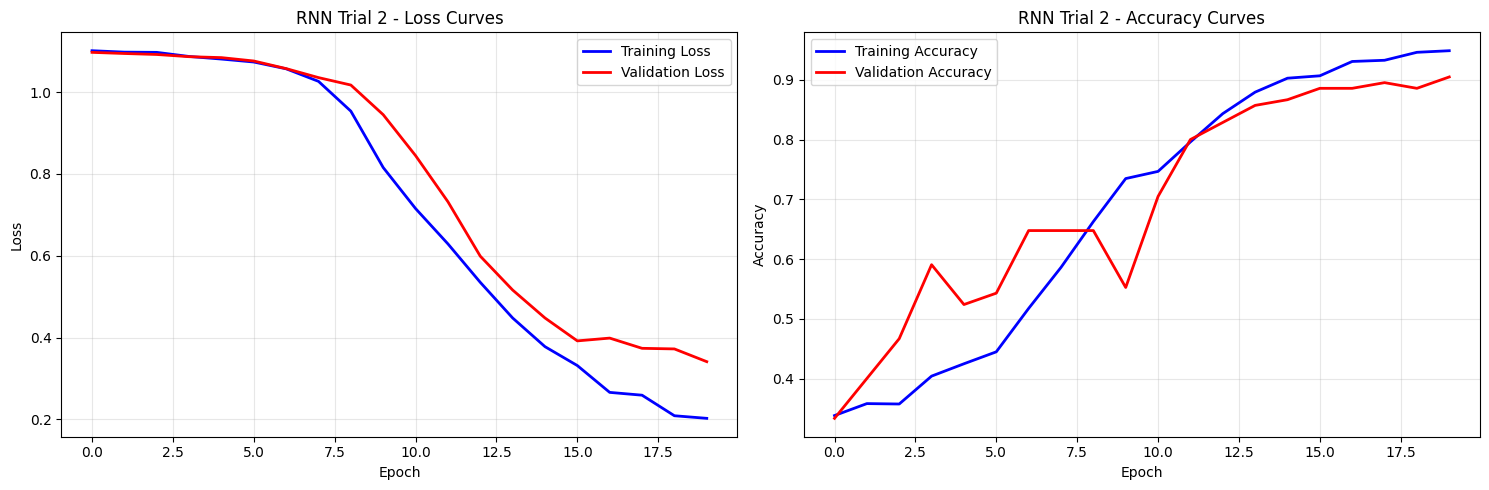

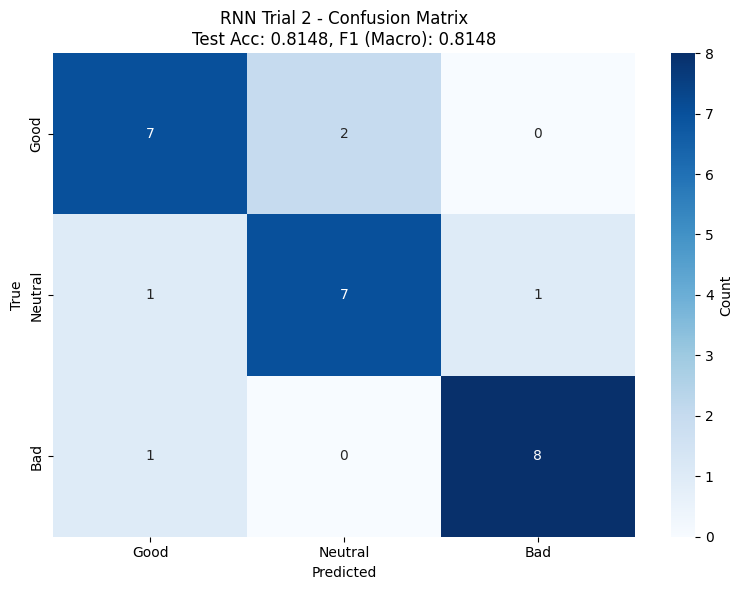


RNN Trial 3/3:
Parameters: {'units': 64, 'dropout': 0.5094418184964681, 'recurrent_dropout': 0.2680501033035984, 'dense_units': 32, 'learning_rate': 0.001, 'use_bidirectional': False, 'use_global_avg_pool': True, 'use_batch_norm': True, 'embedding_dropout': 0.17598546012746746}

Training RNN Trial 3...
Epoch 1/20
47/47 [==============================] - 6s 118ms/step - loss: 1.6761 - accuracy: 0.3913 - val_loss: 1.1683 - val_accuracy: 0.1143 - lr: 0.0010
Epoch 2/20
47/47 [==============================] - 5s 105ms/step - loss: 1.1350 - accuracy: 0.5227 - val_loss: 1.1235 - val_accuracy: 0.2190 - lr: 0.0010
Epoch 3/20
47/47 [==============================] - 5s 103ms/step - loss: 0.7637 - accuracy: 0.6760 - val_loss: 0.9796 - val_accuracy: 0.5524 - lr: 0.0010
Epoch 4/20
47/47 [==============================] - 5s 108ms/step - loss: 0.5421 - accuracy: 0.7833 - val_loss: 0.7647 - val_accuracy: 0.8095 - lr: 0.0010
Epoch 5/20
47/47 [==============================] - 5s 106ms/step - loss: 0

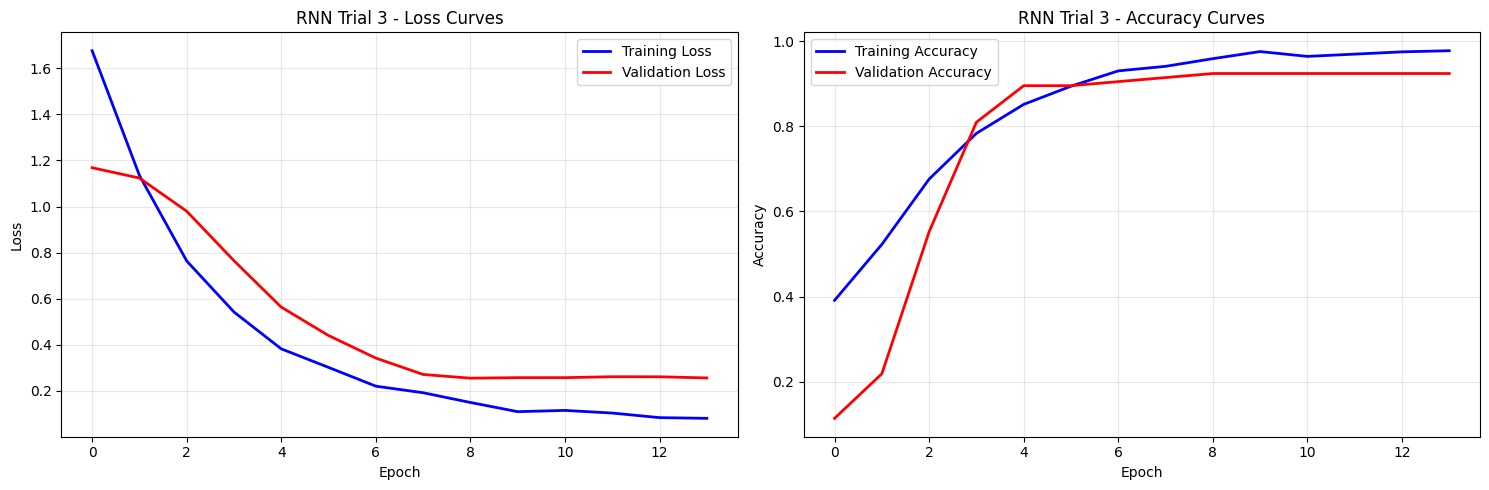

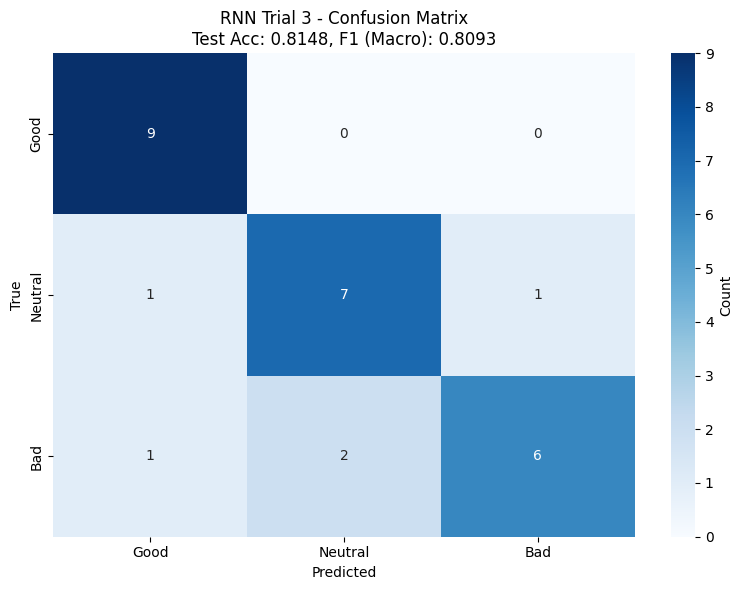


★ NEW BEST RNN: 0.9238 validation accuracy! ★

RNN TRIALS SUMMARY
Trial  Val_Acc  Test_Acc  F1_Macro  Overfit 
---------------------------------------------
1      0.9143   0.7407    0.7392    0.0750  
2      0.9048   0.8148    0.8148    0.0439  
3      0.9238   0.8148    0.8093    0.0535  
Best: Trial 3 with 0.9238 val accuracy

GRU RANDOM SEARCH HYPERPARAMETER TUNING

GRU Trial 1/3:
Parameters: {'units': 64, 'dropout': 0.5189195360081453, 'recurrent_dropout': 0.30724561829094016, 'dense_units': 64, 'learning_rate': 0.001, 'use_bidirectional': False, 'use_global_avg_pool': False, 'use_batch_norm': True, 'embedding_dropout': 0.24091436724298468}

Training GRU Trial 1...
Epoch 1/20
47/47 [==============================] - 15s 285ms/step - loss: 1.5608 - accuracy: 0.4147 - val_loss: 1.0241 - val_accuracy: 0.7619 - lr: 0.0010
Epoch 2/20
47/47 [==============================] - 14s 304ms/step - loss: 0.8546 - accuracy: 0.6380 - val_loss: 0.9217 - val_accuracy: 0.7810 - lr: 0.0010
Epoch 3/

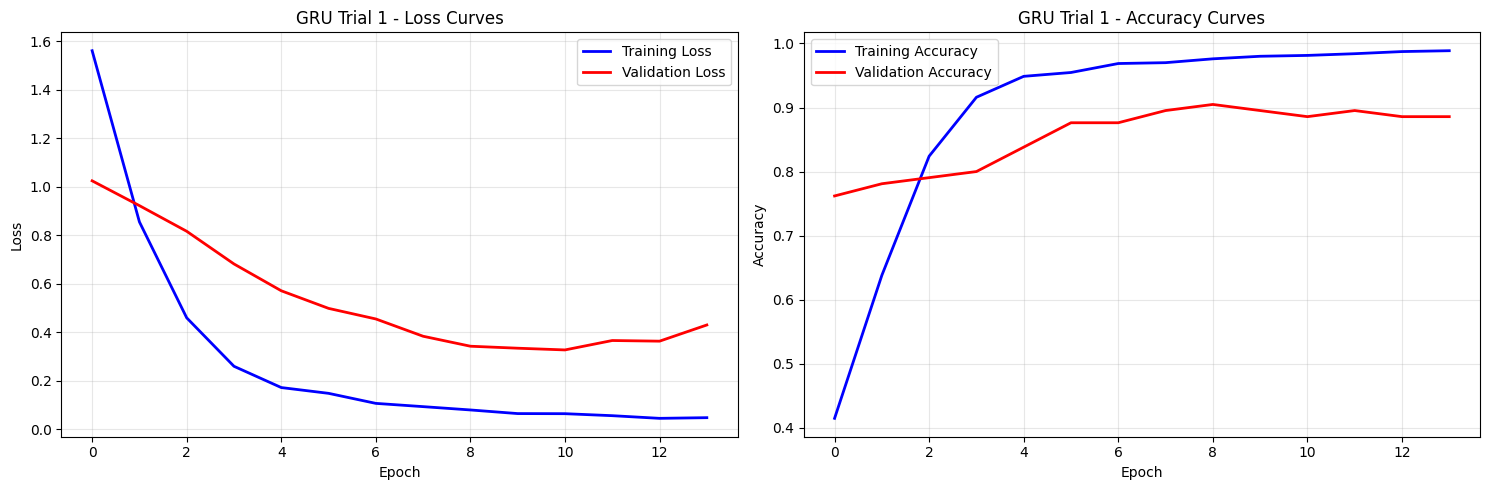

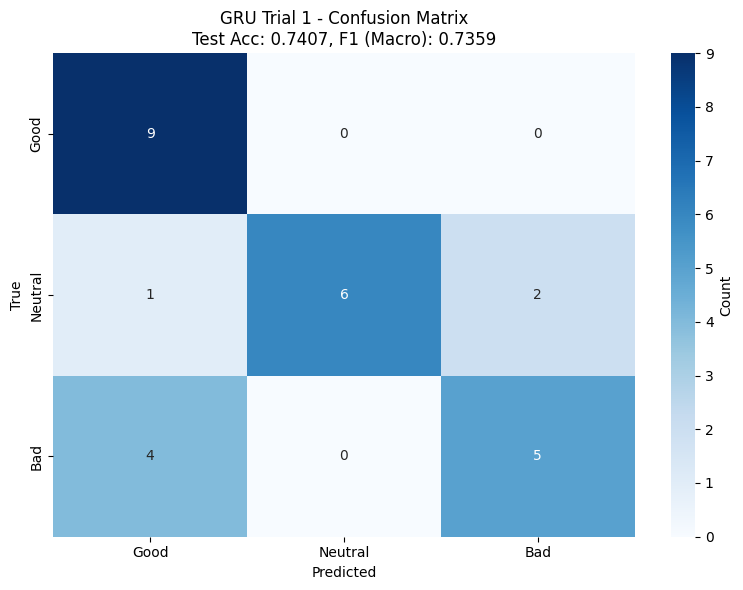


★ NEW BEST GRU: 0.9048 validation accuracy! ★

GRU Trial 2/3:
Parameters: {'units': 64, 'dropout': 0.5565953163045441, 'recurrent_dropout': 0.37329673335105396, 'dense_units': 64, 'learning_rate': 0.0005, 'use_bidirectional': False, 'use_global_avg_pool': False, 'use_batch_norm': True, 'embedding_dropout': 0.17403619342337653}

Training GRU Trial 2...
Epoch 1/20
47/47 [==============================] - 15s 278ms/step - loss: 1.6390 - accuracy: 0.3993 - val_loss: 1.1923 - val_accuracy: 0.0857 - lr: 5.0000e-04
Epoch 2/20
47/47 [==============================] - 13s 283ms/step - loss: 1.3151 - accuracy: 0.4753 - val_loss: 1.2670 - val_accuracy: 0.0857 - lr: 5.0000e-04
Epoch 3/20
47/47 [==============================] - 13s 274ms/step - loss: 1.0544 - accuracy: 0.5713 - val_loss: 1.2916 - val_accuracy: 0.1143 - lr: 5.0000e-04
Epoch 4/20
47/47 [==============================] - ETA: 0s - loss: 0.7544 - accuracy: 0.6753
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743

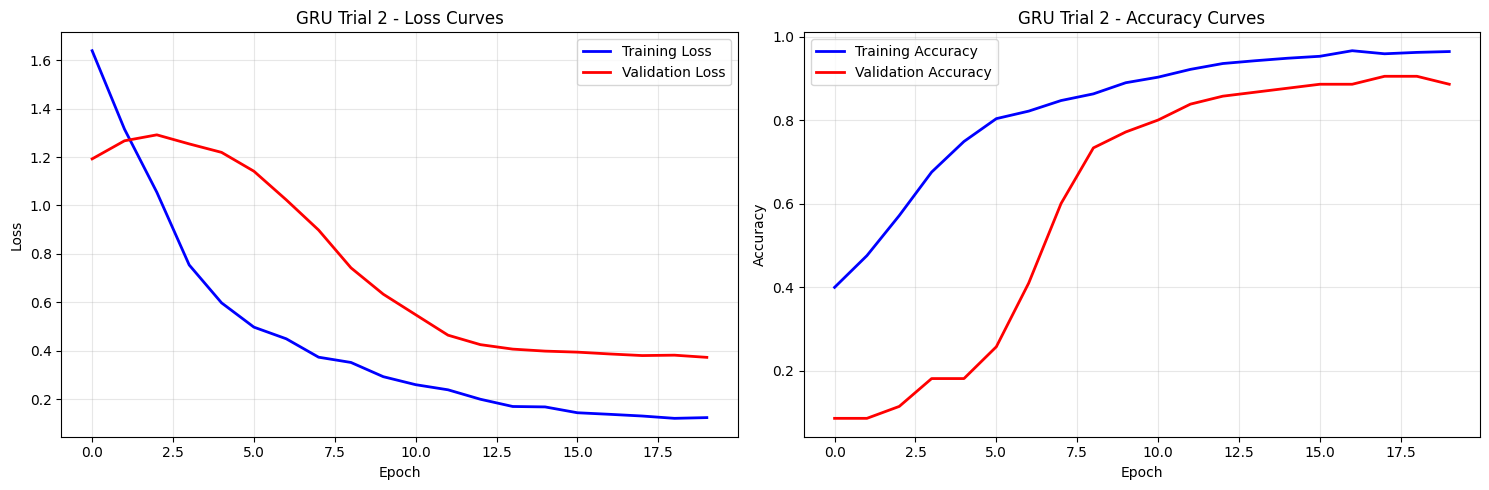

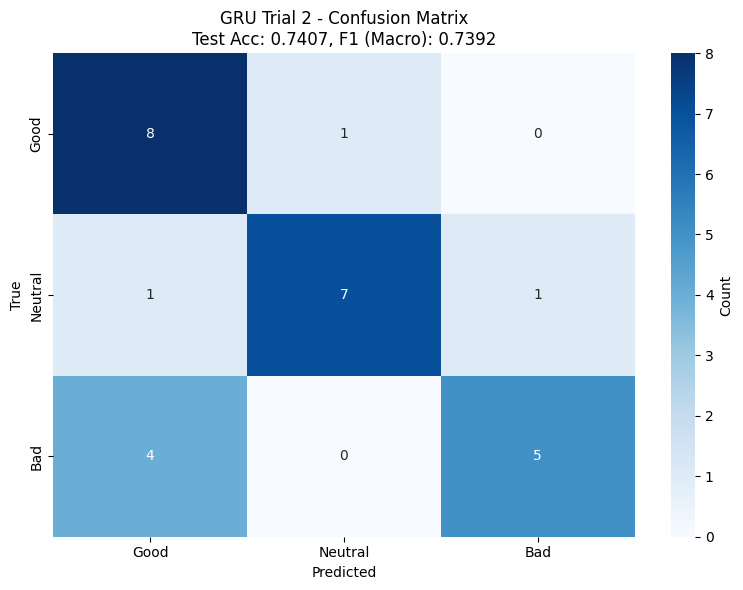


GRU Trial 3/3:
Parameters: {'units': 256, 'dropout': 0.3214207528735645, 'recurrent_dropout': 0.3269956576394121, 'dense_units': 128, 'learning_rate': 0.0001, 'use_bidirectional': True, 'use_global_avg_pool': True, 'use_batch_norm': False, 'embedding_dropout': 0.17589108835152956}

Training GRU Trial 3...
Epoch 1/20
47/47 [==============================] - 28s 548ms/step - loss: 1.0919 - accuracy: 0.5193 - val_loss: 1.0820 - val_accuracy: 0.7524 - lr: 1.0000e-04
Epoch 2/20
47/47 [==============================] - 26s 552ms/step - loss: 1.0627 - accuracy: 0.7760 - val_loss: 1.0315 - val_accuracy: 0.8190 - lr: 1.0000e-04
Epoch 3/20
47/47 [==============================] - 25s 534ms/step - loss: 0.9301 - accuracy: 0.8953 - val_loss: 0.8250 - val_accuracy: 0.8476 - lr: 1.0000e-04
Epoch 4/20
47/47 [==============================] - 26s 553ms/step - loss: 0.4347 - accuracy: 0.9540 - val_loss: 0.5013 - val_accuracy: 0.8762 - lr: 1.0000e-04
Epoch 5/20
47/47 [==============================] - 

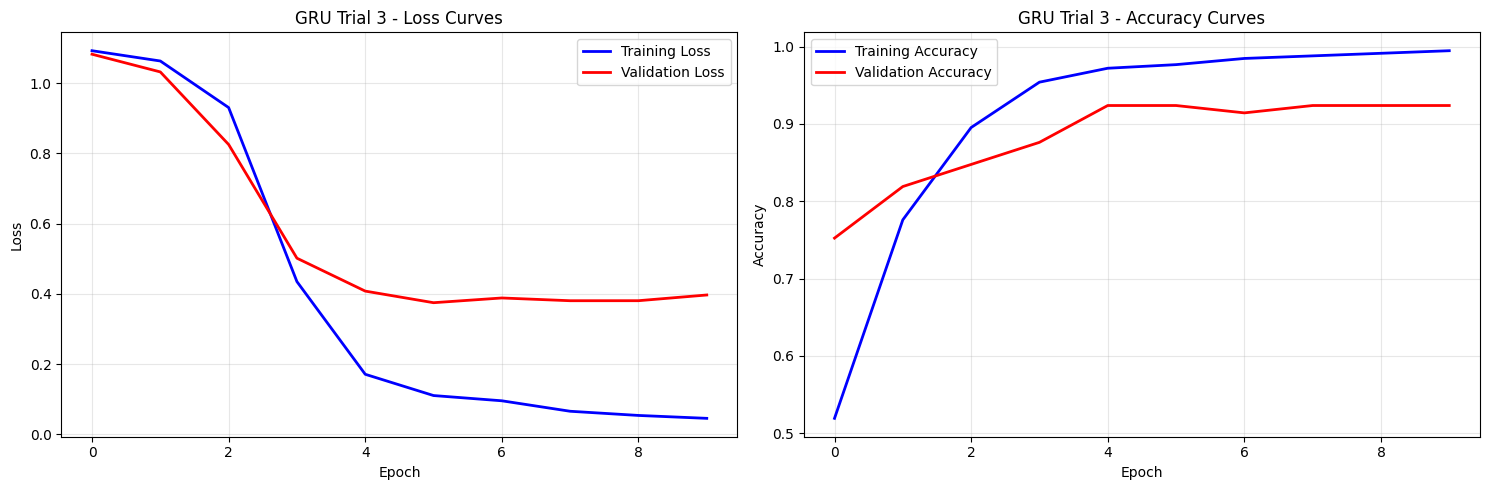

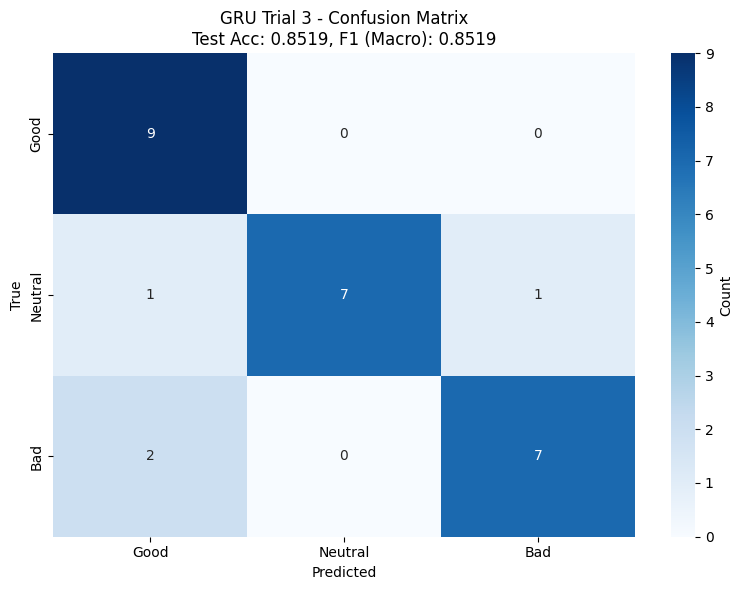


★ NEW BEST GRU: 0.9238 validation accuracy! ★

GRU TRIALS SUMMARY
Trial  Val_Acc  Test_Acc  F1_Macro  Overfit 
---------------------------------------------
1      0.9048   0.7407    0.7359    0.0839  
2      0.8857   0.7407    0.7392    0.0803  
3      0.9238   0.8519    0.8519    0.0709  
Best: Trial 3 with 0.9238 val accuracy

LSTM RANDOM SEARCH HYPERPARAMETER TUNING

LSTM Trial 1/3:
Parameters: {'units': 64, 'dropout': 0.3687144215892313, 'recurrent_dropout': 0.20642004878080755, 'dense_units': 64, 'learning_rate': 0.0005, 'use_bidirectional': False, 'use_global_avg_pool': True, 'use_batch_norm': True, 'embedding_dropout': 0.282627224837109}

Training LSTM Trial 1...
Epoch 1/20
47/47 [==============================] - 16s 301ms/step - loss: 1.3246 - accuracy: 0.4827 - val_loss: 1.0974 - val_accuracy: 0.2190 - lr: 5.0000e-04
Epoch 2/20
47/47 [==============================] - 14s 300ms/step - loss: 0.5806 - accuracy: 0.7593 - val_loss: 1.0571 - val_accuracy: 0.7714 - lr: 5.0000e-04

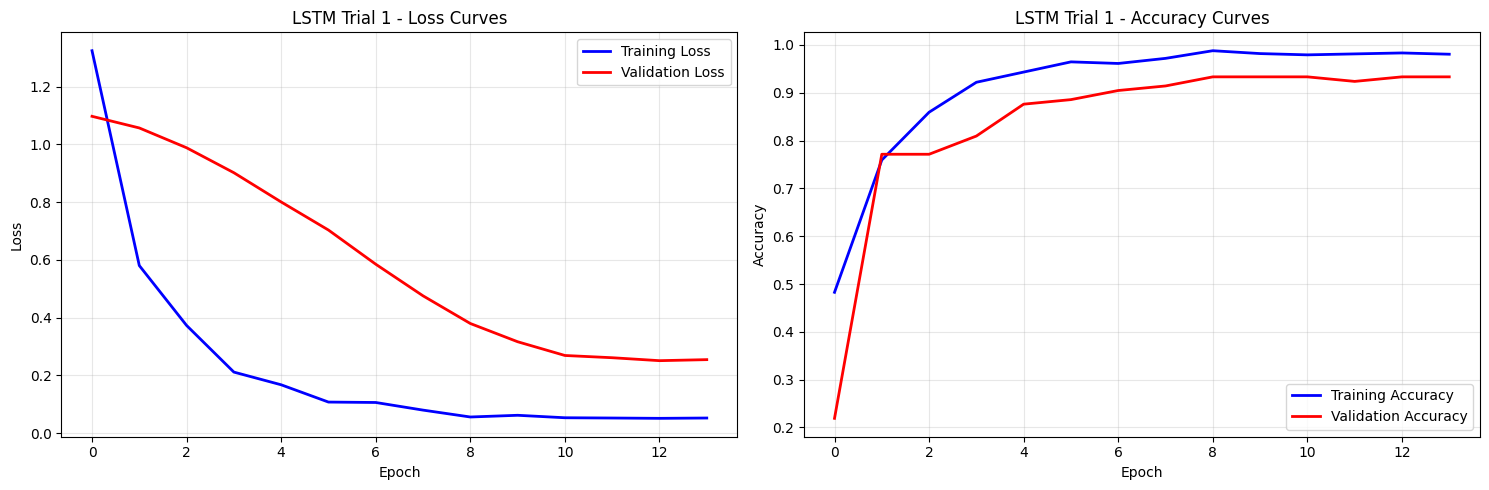

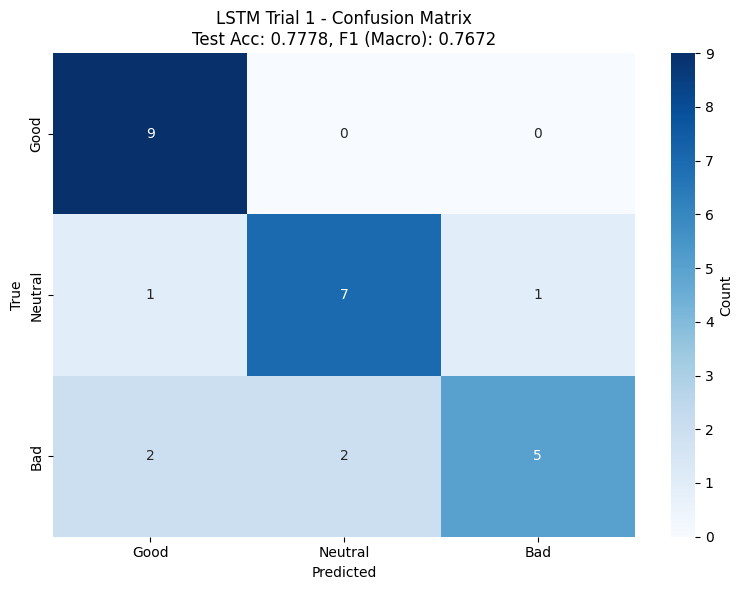


★ NEW BEST LSTM: 0.9333 validation accuracy! ★

LSTM Trial 2/3:
Parameters: {'units': 256, 'dropout': 0.44976937784768317, 'recurrent_dropout': 0.3769366307773405, 'dense_units': 128, 'learning_rate': 0.0005, 'use_bidirectional': True, 'use_global_avg_pool': False, 'use_batch_norm': True, 'embedding_dropout': 0.1493255015387967}

Training LSTM Trial 2...
Epoch 1/20
47/47 [==============================] - 33s 638ms/step - loss: 0.9397 - accuracy: 0.6460 - val_loss: 0.9950 - val_accuracy: 0.6952 - lr: 5.0000e-04
Epoch 2/20
47/47 [==============================] - 30s 640ms/step - loss: 0.2820 - accuracy: 0.8967 - val_loss: 0.8689 - val_accuracy: 0.6952 - lr: 5.0000e-04
Epoch 3/20
47/47 [==============================] - 29s 622ms/step - loss: 0.1351 - accuracy: 0.9500 - val_loss: 0.7545 - val_accuracy: 0.6952 - lr: 5.0000e-04
Epoch 4/20
47/47 [==============================] - 28s 596ms/step - loss: 0.0824 - accuracy: 0.9720 - val_loss: 0.6726 - val_accuracy: 0.6952 - lr: 5.0000e-04
Ep

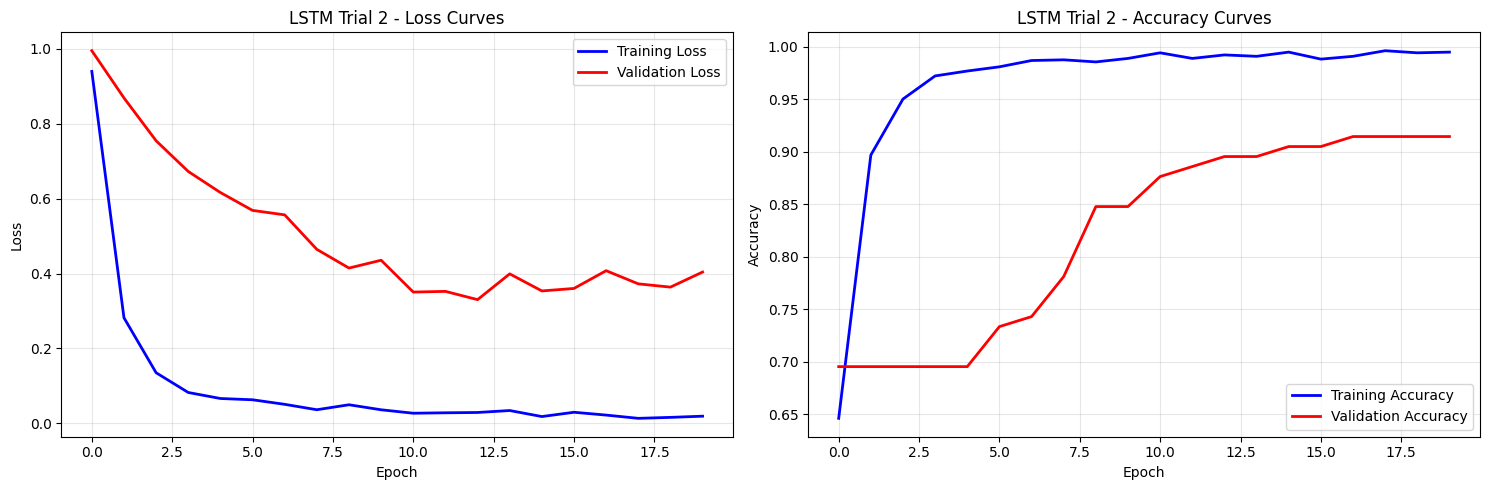

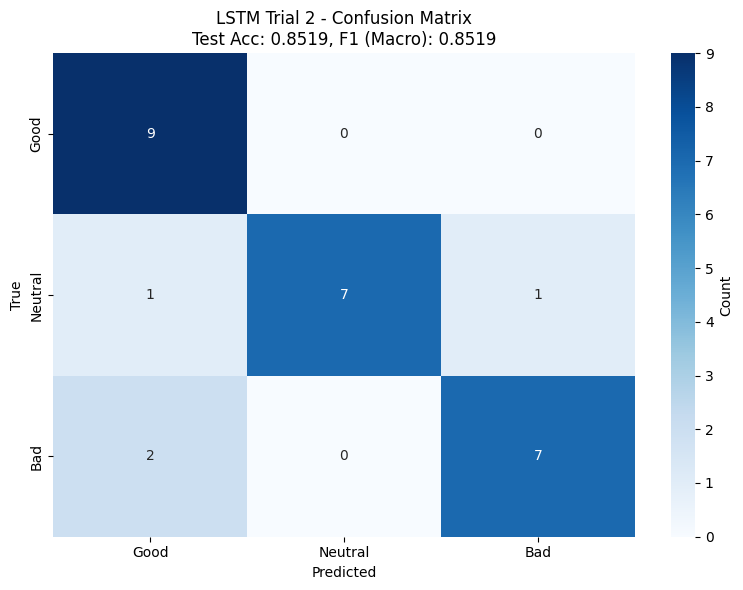


LSTM Trial 3/3:
Parameters: {'units': 256, 'dropout': 0.41982015154211916, 'recurrent_dropout': 0.24386415183145668, 'dense_units': 32, 'learning_rate': 0.0001, 'use_bidirectional': False, 'use_global_avg_pool': True, 'use_batch_norm': True, 'embedding_dropout': 0.27222058193333315}

Training LSTM Trial 3...
Epoch 1/20
47/47 [==============================] - 18s 345ms/step - loss: 1.4152 - accuracy: 0.4047 - val_loss: 1.1017 - val_accuracy: 0.0952 - lr: 1.0000e-04
Epoch 2/20
47/47 [==============================] - 15s 315ms/step - loss: 1.0530 - accuracy: 0.5573 - val_loss: 1.0985 - val_accuracy: 0.1810 - lr: 1.0000e-04
Epoch 3/20
47/47 [==============================] - 15s 325ms/step - loss: 0.8723 - accuracy: 0.6260 - val_loss: 1.0905 - val_accuracy: 0.3714 - lr: 1.0000e-04
Epoch 4/20
47/47 [==============================] - 16s 343ms/step - loss: 0.7389 - accuracy: 0.6920 - val_loss: 1.0663 - val_accuracy: 0.6476 - lr: 1.0000e-04
Epoch 5/20
47/47 [==============================]

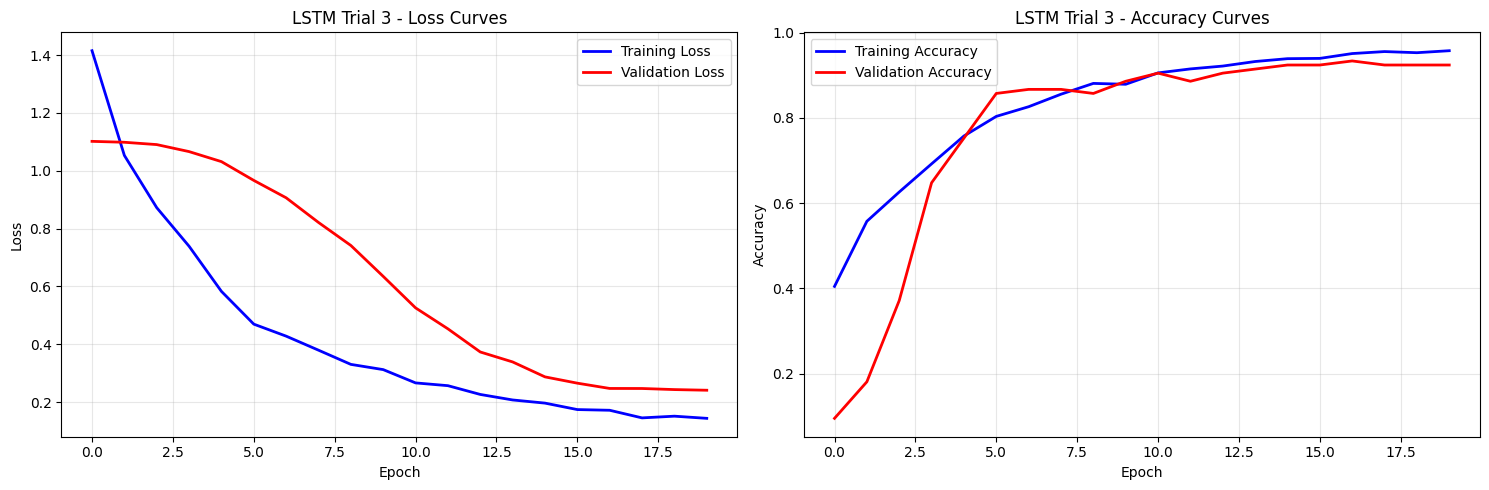

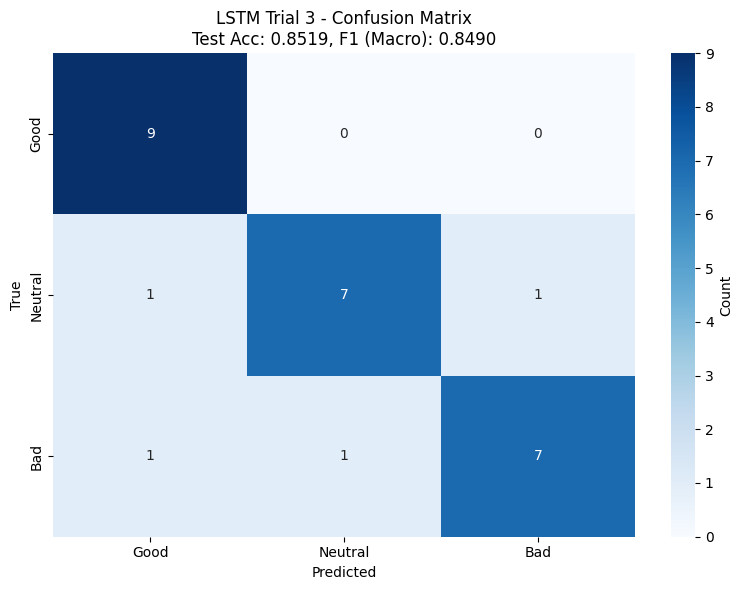


LSTM TRIALS SUMMARY
Trial  Val_Acc  Test_Acc  F1_Macro  Overfit 
---------------------------------------------
1      0.9333   0.7778    0.7672    0.0547  
2      0.9143   0.8519    0.8519    0.0817  
3      0.9238   0.8519    0.8490    0.0335  
Best: Trial 1 with 0.9333 val accuracy

ENHANCED MODEL COMPARISON (Random Search Results)
RNN    - Best Val Acc: 0.9238 (Trial 3)
GRU    - Best Val Acc: 0.9238 (Trial 3)
LSTM   - Best Val Acc: 0.9333 (Trial 1)

COMPREHENSIVE RESULTS SUMMARY
Model  Val_Acc  Test_Acc  F1_Macro  F1_Wght   Overfit  Trial 
----------------------------------------------------------------------
RNN    0.9238   0.8148    0.8093    0.8093    0.0535   3     
GRU    0.9238   0.8519    0.8519    0.8519    0.0709   3     
LSTM   0.9333   0.7778    0.7672    0.7672    0.0547   1     

FINAL BEST MODEL SUMMARIES

FINAL BEST MODEL SUMMARY: RNN
Best parameters: {'units': 64, 'dropout': 0.5094418184964681, 'recurrent_dropout': 0.2680501033035984, 'dense_units': 32, 'learning_ra

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Embedding, LSTM, GRU, SimpleRNN, Dense, Dropout, 
                                   BatchNormalization, GlobalAveragePooling1D, Bidirectional)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import random

# Extract data
X_train = results['sequences']['X_train']
X_val = results['sequences']['X_val'] 
X_test = results['sequences']['X_test']
y_train = results['sequences']['y_train']
y_val = results['sequences']['y_val']
y_test = results['sequences']['y_test']
vocab_size = len(results['vocabulary']['vocab_to_idx'])

# Calculate class weights to help with neutral class
y_train_labels = np.argmax(y_train, axis=1)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weight_dict = dict(enumerate(class_weights))
print(f"Class weights: {class_weight_dict}")
print("Higher weight on struggling classes (especially Neutral)")

# =============================================================================
# ENHANCED MODEL CREATION WITH OVERFITTING REDUCTION
# =============================================================================

def create_enhanced_model(model_type='lstm', units=128, dropout=0.4, recurrent_dropout=0.3,
                         dense_units=64, learning_rate=0.001, use_bidirectional=False,
                         use_global_avg_pool=True, use_batch_norm=True, 
                         embedding_dropout=0.2):

    model = Sequential()
    
    # Embedding layer with dropout
    model.add(Embedding(vocab_size, 100, input_length=100, mask_zero=True))
    if embedding_dropout > 0:
        model.add(Dropout(embedding_dropout))
    
    # RNN layer selection
    if model_type.lower() == 'lstm':
        rnn_layer = LSTM(units, dropout=dropout, recurrent_dropout=recurrent_dropout, 
                        return_sequences=use_global_avg_pool)
    elif model_type.lower() == 'gru':
        rnn_layer = GRU(units, dropout=dropout, recurrent_dropout=recurrent_dropout,
                       return_sequences=use_global_avg_pool)
    elif model_type.lower() == 'rnn':
        rnn_layer = SimpleRNN(units, dropout=dropout, recurrent_dropout=recurrent_dropout,
                             return_sequences=use_global_avg_pool)
    else:
        raise ValueError("model_type must be 'lstm', 'gru', or 'rnn'")
    
    # Apply bidirectional wrapper if requested
    if use_bidirectional:
        rnn_layer = Bidirectional(rnn_layer)
    
    model.add(rnn_layer)
    
    # Global Average Pooling (helps reduce overfitting)
    if use_global_avg_pool:
        model.add(GlobalAveragePooling1D())
    
    # Batch normalization
    if use_batch_norm:
        model.add(BatchNormalization())
    
    # Dense layers with dropout
    model.add(Dropout(dropout))
    model.add(Dense(dense_units, activation='relu'))
    
    if use_batch_norm:
        model.add(BatchNormalization())
    
    model.add(Dropout(dropout))
    model.add(Dense(3, activation='softmax'))
    
    # Compile model
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# =============================================================================
# RANDOM SEARCH HYPERPARAMETER TUNING
# =============================================================================

def random_search_params():
    """Generate random hyperparameters for each trial"""
    return {
        'units': random.choice([64, 128, 256]),
        'dropout': random.uniform(0.3, 0.6),
        'recurrent_dropout': random.uniform(0.2, 0.4),
        'dense_units': random.choice([32, 64, 128]),
        'learning_rate': random.choice([0.001, 0.0005, 0.0001]),
        'use_bidirectional': random.choice([True, False]),
        'use_global_avg_pool': random.choice([True, False]),
        'use_batch_norm': random.choice([True, False]),
        'embedding_dropout': random.uniform(0.1, 0.3)
    }

def evaluate_model_trial(model, model_type, trial_num, params, history):
    """Detailed evaluation for each model trial"""
    print(f"\n" + "-"*50)
    print(f"DETAILED EVALUATION: {model_type.upper()} Trial {trial_num}")
    print("-"*50)
    print(f"Parameters: {params}")
    
    # Test predictions
    y_pred = model.predict(X_test, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    # Calculate comprehensive metrics
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    f1_macro = f1_score(y_true, y_pred_classes, average='macro')
    f1_weighted = f1_score(y_true, y_pred_classes, average='weighted')
    
    print(f"\nTEST METRICS:")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"F1 Score (Macro): {f1_macro:.4f}")
    print(f"F1 Score (Weighted): {f1_weighted:.4f}")
    
    # Overfitting analysis
    if history:
        final_train_acc = history.history['accuracy'][-1]
        final_val_acc = history.history['val_accuracy'][-1]
        overfitting_gap = final_train_acc - final_val_acc
        print(f"\nOVERFITTING ANALYSIS:")
        print(f"Final Train Accuracy: {final_train_acc:.4f}")
        print(f"Final Val Accuracy: {final_val_acc:.4f}")
        print(f"Overfitting Gap: {overfitting_gap:.4f}")
    
    # Classification report
    class_names = ['Good', 'Neutral', 'Bad']
    print(f"\nCLASSIFICATION REPORT:")
    print(classification_report(y_true, y_pred_classes, target_names=class_names))
    
    # Plot training curves
    if history:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Loss curves
        ax1.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
        ax1.plot(history.history['val_loss'], label='Validation Loss', color='red', linewidth=2)
        ax1.set_title(f'{model_type.upper()} Trial {trial_num} - Loss Curves')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Accuracy curves
        ax2.plot(history.history['accuracy'], label='Training Accuracy', color='blue', linewidth=2)
        ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red', linewidth=2)
        ax2.set_title(f'{model_type.upper()} Trial {trial_num} - Accuracy Curves')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'{model_type.upper()} Trial {trial_num} - Confusion Matrix\nTest Acc: {test_acc:.4f}, F1 (Macro): {f1_macro:.4f}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()
    
    return {
        'test_acc': test_acc,
        'test_loss': test_loss,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'overfitting_gap': overfitting_gap if history else None
    }

def tune_model_type(model_type, num_trials=3):
    """Random search hyperparameter tuning for specific model type"""
    print(f"\n" + "="*60)
    print(f"{model_type.upper()} RANDOM SEARCH HYPERPARAMETER TUNING")
    print("="*60)
    
    best_val_acc = 0
    best_params = None
    best_model = None
    all_results = []
    
    for trial in range(num_trials):
        # Generate random parameters
        params = random_search_params()
        
        print(f"\n{model_type.upper()} Trial {trial+1}/{num_trials}:")
        print(f"Parameters: {params}")
        
        try:
            # Create model
            model = create_enhanced_model(model_type=model_type, **params)
            
            # Enhanced callbacks for overfitting reduction
            callbacks = [
                EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
            ]
            
            print(f"\nTraining {model_type.upper()} Trial {trial+1}...")
            # Train model with verbose output
            history = model.fit(X_train, y_train,
                              validation_data=(X_val, y_val),
                              epochs=20,  # Increased epochs since we have early stopping
                              batch_size=32,
                              class_weight=class_weight_dict,
                              callbacks=callbacks,
                              verbose=1)  # Show training progress
            
            # Evaluate
            print(f"\nEvaluating {model_type.upper()} Trial {trial+1}...")
            val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
            test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
            
            # Calculate overfitting metric (difference between train and val accuracy)
            train_acc = max(history.history['accuracy'])
            overfitting_score = train_acc - val_acc
            
            print(f"\nQUICK RESULTS:")
            print(f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")
            print(f"Overfitting Score: {overfitting_score:.4f} (lower is better)")
            
            # Detailed evaluation with plots for this trial
            detailed_metrics = evaluate_model_trial(model, model_type, trial+1, params, history)
            
            result = {
                'trial': trial + 1,
                'params': params.copy(),
                'val_acc': val_acc,
                'test_acc': test_acc,
                'train_acc': train_acc,
                'overfitting_score': overfitting_score,
                'model': model,
                'history': history,
                'detailed_metrics': detailed_metrics
            }
            all_results.append(result)
            
            # Update best model based on validation accuracy
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_params = params.copy()
                best_model = model
                print(f"\n★ NEW BEST {model_type.upper()}: {val_acc:.4f} validation accuracy! ★")
        
        except Exception as e:
            print(f"Trial {trial+1} failed: {str(e)}")
            continue
    
    return best_model, best_params, best_val_acc, all_results

# =============================================================================
# DETAILED EVALUATION WITH OVERFITTING ANALYSIS
# =============================================================================

def detailed_evaluation_enhanced(model, model_name, params, history=None):
    """Enhanced evaluation for final best model summary"""
    print(f"\n" + "="*60)
    print(f"FINAL BEST MODEL SUMMARY: {model_name}")
    print("="*60)
    print(f"Best parameters: {params}")
    
    # Test predictions
    y_pred = model.predict(X_test, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    # Comprehensive metrics
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    f1_macro = f1_score(y_true, y_pred_classes, average='macro')
    f1_weighted = f1_score(y_true, y_pred_classes, average='weighted')
    
    print(f"\nFINAL TEST METRICS:")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"F1 Score (Macro): {f1_macro:.4f}")
    print(f"F1 Score (Weighted): {f1_weighted:.4f}")
    
    # Overfitting analysis
    if history:
        final_train_acc = history.history['accuracy'][-1]
        final_val_acc = history.history['val_accuracy'][-1]
        overfitting_gap = final_train_acc - final_val_acc
        print(f"\nOVERFITTING ANALYSIS:")
        print(f"Final Train Accuracy: {final_train_acc:.4f}")
        print(f"Final Val Accuracy: {final_val_acc:.4f}")
        print(f"Overfitting Gap: {overfitting_gap:.4f}")
    
    # Classification report
    class_names = ['Good', 'Neutral', 'Bad']
    print(f"\nFINAL CLASSIFICATION REPORT:")
    print(classification_report(y_true, y_pred_classes, target_names=class_names))
    
    return test_acc

# =============================================================================
# RUN ENHANCED TUNING FOR ALL MODEL TYPES
# =============================================================================

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

model_types = ['rnn', 'gru', 'lstm']
all_best_models = {}
all_best_params = {}
all_best_scores = {}
all_results = {}

print("Starting Enhanced Random Search Hyperparameter Tuning...")
print("Focus: Reducing overfitting with advanced regularization techniques")

# Tune each model type
for model_type in model_types:
    best_model, best_params, best_score, results = tune_model_type(model_type, num_trials=3)
    
    all_best_models[model_type] = best_model
    all_best_params[model_type] = best_params
    all_best_scores[model_type] = best_score
    all_results[model_type] = results
    
    # Summary for this model type
    print(f"\n" + "="*50)
    print(f"{model_type.upper()} TRIALS SUMMARY")
    print("="*50)
    if results:
        print(f"{'Trial':<6} {'Val_Acc':<8} {'Test_Acc':<9} {'F1_Macro':<9} {'Overfit':<8}")
        print("-" * 45)
        for result in results:
            metrics = result['detailed_metrics']
            print(f"{result['trial']:<6} {result['val_acc']:<8.4f} {result['test_acc']:<9.4f} "
                  f"{metrics['f1_macro']:<9.4f} {result['overfitting_score']:<8.4f}")
        print(f"Best: Trial {np.argmax([r['val_acc'] for r in results]) + 1} with {best_score:.4f} val accuracy")
    else:
        print("No successful trials completed")


# Compare all models
print(f"\n" + "="*70)
print("ENHANCED MODEL COMPARISON (Random Search Results)")
print("="*70)

best_overall_model = None
best_overall_score = 0
best_overall_type = None

# Create comprehensive comparison table
comparison_results = []
for model_type in model_types:
    if all_best_scores[model_type] > 0:  # Check if we got valid results
        score = all_best_scores[model_type]
        
        # Find best result details
        best_result = None
        for result in all_results[model_type]:
            if result['val_acc'] == score:
                best_result = result
                break
        
        if best_result:
            comparison_results.append({
                'Model': model_type.upper(),
                'Val_Acc': f"{score:.4f}",
                'Test_Acc': f"{best_result['test_acc']:.4f}",
                'F1_Macro': f"{best_result['detailed_metrics']['f1_macro']:.4f}",
                'F1_Weighted': f"{best_result['detailed_metrics']['f1_weighted']:.4f}",
                'Overfitting_Gap': f"{best_result['overfitting_score']:.4f}",
                'Trial': best_result['trial']
            })
        
        print(f"{model_type.upper():<6} - Best Val Acc: {score:.4f} (Trial {best_result['trial'] if best_result else 'N/A'})")
        
        if score > best_overall_score:
            best_overall_score = score
            best_overall_model = all_best_models[model_type]
            best_overall_type = model_type

# Print comprehensive comparison table
print(f"\n" + "="*70)
print("COMPREHENSIVE RESULTS SUMMARY")
print("="*70)
print(f"{'Model':<6} {'Val_Acc':<8} {'Test_Acc':<9} {'F1_Macro':<9} {'F1_Wght':<9} {'Overfit':<8} {'Trial':<6}")
print("-" * 70)
for result in comparison_results:
    print(f"{result['Model']:<6} {result['Val_Acc']:<8} {result['Test_Acc']:<9} "
          f"{result['F1_Macro']:<9} {result['F1_Weighted']:<9} {result['Overfitting_Gap']:<8} {result['Trial']:<6}")

# Detailed evaluation of best models
print(f"\n" + "="*70)
print("FINAL BEST MODEL SUMMARIES")
print("="*70)

final_test_scores = {}
for model_type in model_types:
    if all_best_models[model_type] is not None:
        # Find the best result for history
        best_result = None
        for result in all_results[model_type]:
            if result['val_acc'] == all_best_scores[model_type]:
                best_result = result
                break
        
        history = best_result['history'] if best_result else None
        test_acc = detailed_evaluation_enhanced(
            all_best_models[model_type], 
            model_type.upper(), 
            all_best_params[model_type],
            history
        )
        final_test_scores[model_type] = test_acc

# Final winner announcement
if best_overall_type:
    print(f"\n OVERALL WINNER: {best_overall_type.upper()} with {best_overall_score:.4f} validation accuracy!")
    print(f"Final test accuracy: {final_test_scores.get(best_overall_type, 'N/A'):.4f}")
    
    # Save best model
    model_filename = f'best_enhanced_{best_overall_type}_model.h5'
    best_overall_model.save(model_filename)
    print(f"Best model saved as: {model_filename}")
else:
    print("\n No successful models completed training")

# Performance improvement analysis
print(f"\n" + "="*70)
print("PERFORMANCE IMPROVEMENT ANALYSIS")
print("="*70)
baseline_acc = 0.8462  # Your baseline accuracy
print(f"Baseline Accuracy: {baseline_acc:.4f}")

if comparison_results:
    best_enhanced = max([float(r['Test_Acc']) for r in comparison_results])
    improvement = best_enhanced - baseline_acc
    improvement_pct = (improvement / baseline_acc) * 100
    
    print(f"Best Enhanced Accuracy: {best_enhanced:.4f}")
    print(f"Improvement: {improvement:+.4f} ({improvement_pct:+.2f}%)")
    
    # Check overfitting reduction
    best_overfitting = min([float(r['Overfitting_Gap']) for r in comparison_results])
    print(f"Best Overfitting Gap: {best_overfitting:.4f} (lower is better)")



## Model Evaluation Summary

### **Test Metrics**:
- **Test Accuracy**: 0.8519  
- **Test Loss**: 0.3710  
- **F1 Score (Macro)**: 0.8490  
- **F1 Score (Weighted)**: 0.8490  

The model performs well with a test accuracy of 85.19%, and both the F1 score (macro and weighted) are close, showing a balanced performance across different classes. The test loss is relatively low, indicating good generalization to unseen data.

### **Overfitting Analysis**:
- **Final Train Accuracy**: 0.9573  
- **Final Validation Accuracy**: 0.9238  
- **Overfitting Gap**: 0.0335  

There is a slight gap between training and validation accuracy (3.35%), indicating a small amount of overfitting. However, the gap is relatively low, suggesting that the model generalizes well without significant overfitting.

### **Confusion Matrix**:
- The confusion matrix shows that the model performs excellently for the "Good" class with no misclassifications. However, there is some misclassification between "Neutral" and "Bad" classes, with a few samples being misclassified as other classes.

### **Classification Report**:
| Class   | Precision | Recall | F1-Score | Support |
|---------|-----------|--------|----------|---------|
| Good    | 0.82      | 1.00   | 0.90     | 9       |
| Neutral | 0.88      | 0.78   | 0.82     | 9       |
| Bad     | 0.88      | 0.78   | 0.82     | 9       |
| **Accuracy**  | -         | -      | **0.85** | 27      |
| **Macro Avg** | 0.86      | 0.85   | **0.85** | 27      |
| **Weighted Avg** | 0.86   | 0.85   | **0.85** | 27      |

- **Precision**: The model performs well in precision for all classes.
- **Recall**: The recall for "Neutral" and "Bad" classes is lower, indicating that these classes are harder to predict.
- **F1-Score**: The F1-score is balanced for all classes, with the model showing strong performance on the "Good" class and moderate performance on the "Neutral" and "Bad" classes.

### **Overall Evaluation**:
The model achieves a good balance between accuracy and F1 scores across different classes. The slight overfitting and minor misclassifications in "Neutral" and "Bad" classes can be improved with additional tuning or data augmentation.
